In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict

### change directory to import more scripts
sys.path.append(str(Path().resolve().parents[0]))

from utils import tools
import generate_wind

if os.getcwd().split(os.sep)[-1] == 'evaluation':
    os.chdir('..')

In [2]:
config = tools.load_config("config.yaml")

val_dir = config['data']['re_ninja_dir']
synth_dir = os.path.join(config['data']['synth_dir'], 'ex_noise', 'wind_age')
turbine_dir = config['data']['turbine_dir']
turbine_power = config['data']['turbine_power']
turbine_path = os.path.join(turbine_dir, turbine_power)
specs_path = config['data']['turbine_specs']
specs_path = os.path.join(turbine_dir, specs_path)
cp_path = config["data"]["turbine_cp"]
cp_path = os.path.join(turbine_dir, cp_path)
results_dir = 'results'

os.makedirs(results_dir, exist_ok=True)

features = config['features']

params = config['wind_params']

mapping = {'power_t1': 'Enercon E-70 E4 2.300',
           'power_t2': 'Enercon E-82 E2 2.000',
           'power_t3': 'Enercon E-115 2.500',
           'power_t4': 'Vestas V90',
           'power_t5': 'Vestas V112-3.45',
           'power_t6': 'Vestas V80-1.8'
           }

turbine_mapping = {'electricity_1': 'power_t1',
                    'electricity_2': 'power_t2',
                    'electricity_3': 'power_t3',
                    'electricity_4': 'power_t4',
                    'electricity_5': 'power_t5',
                    'electricity_6': 'power_t6'
                    }

In [3]:
# get validationd data
files = os.listdir(val_dir)
station_files = [f for f in files if 'metadata' not in f and f.endswith('.csv')]
metadata_files = [f for f in files if 'metadata' in f and f.endswith('.csv')]
station_files.sort()
metadata_files.sort()
print(len(station_files), 'station files in validation data found')

files = os.listdir(synth_dir)
station_files_synthetic = [f for f in files if 'parameter' not in f and f.endswith('.csv')]
station_files_synthetic.sort()
print(len(station_files_synthetic), 'station files in synthetic data found')
turbine_params = pd.read_csv(os.path.join(synth_dir, 'turbine_parameter.csv'), sep=';')
wind_params = pd.read_csv(os.path.join(synth_dir, 'wind_parameter.csv'), sep=';', dtype={"park_id": str})

raw_power_curves, cp_curves, specs = generate_wind.get_turbines(turbine_path=turbine_path,
                                                        cp_path=cp_path,
                                                        specs_path=specs_path,
                                                        params=params)
power_curves = pd.DataFrame()
for turbine in raw_power_curves.columns:
    power_curve = generate_wind.interpolate(power_curve=raw_power_curves[turbine],
                                            cut_out=specs[turbine]['cut_out'])
    power_curves[turbine] = power_curve
power_curves /= 1000 # convert to kW

39 station files in validation data found
110 station files in synthetic data found


In [4]:
# filter the list
filtered_list = [
    synth for synth in station_files_synthetic
    if any(synth.split('_')[1].split('.')[0] in station for station in station_files)
]
station_files_synthetic = filtered_list

In [7]:
val_dfs = []
dfs = []

for st, md in zip(station_files, metadata_files):
    station = pd.read_csv(os.path.join(val_dir, st))
    station['datetime'] = pd.to_datetime(station['datetime'], utc=True)
    station.set_index('datetime', inplace=True)
    val_dfs.append(station)
metadata = pd.read_csv(os.path.join(val_dir, md))

for st in station_files_synthetic:
    station = pd.read_csv(os.path.join(synth_dir, st), sep=';')
    station['timestamp'] = pd.to_datetime(station['timestamp'], utc=True)
    station.set_index('timestamp', inplace=True)
    #station = station['2024-01-01':'2024-12-31']
    for key, value in turbine_mapping.items():
        station[value] /= 1000 # convert to kW
    #metadata = pd.read_csv(os.path.join(path, md))
    dfs.append(station)

In [ ]:
def plot_power_curves(data_a, data_b, power_curves, mapping, turbine_mapping, save_path=None):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    fontsize = 14
    for i, turbine in enumerate(map(str, range(1, 7))):
        synthetic_col = turbine_mapping[f'electricity_{turbine}']
        turbine_name = mapping[synthetic_col]

        ax = axes[i]
        sns.scatterplot(data=data_a, x=f'wind_speed_t{turbine}', y=synthetic_col, label=f'synthetic {turbine_name}', ax=ax)
        sns.scatterplot(data=data_b, x=f'wind_speed_{turbine}', y=f'electricity_{turbine}', label=f'renewables.ninja {turbine_name}', ax=ax)
        sns.lineplot(data=power_curves[turbine_name], label=f'power curve {turbine_name}', color='red', linewidth=2, ax=ax)

        ax.set_title(f'Turbine {turbine_name}', fontsize=fontsize)
        ax.set_xlabel('Wind Speed [m/s]', fontsize=fontsize)
        ax.set_ylabel('Power [kW]', fontsize=fontsize)
        ax.tick_params(axis='both', labelsize=fontsize)
        ax.legend()

    #fig.suptitle('Scatterplot of power with power curve', fontsize=fontsize+2)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600)
        plt.close(fig)


def plot_power_distribution(data_a, data_b, mapping, turbine_mapping, save_path=None):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    fontsize = 14
    for i, turbine in enumerate(map(str, range(1, 7))):
        synthetic_col = turbine_mapping[f'electricity_{turbine}']
        turbine_name = mapping[synthetic_col]

        df_ex_zero = data_a[data_a[synthetic_col] > 0]
        val_df_ex_zero = data_b[data_b[f'electricity_{turbine}'] > 0]

        ax = axes[i]
        sns.histplot(data=df_ex_zero, stat='density', x=synthetic_col, label=f'synthetic {turbine_name}', bins=50, kde=True, ax=ax)
        sns.histplot(data=val_df_ex_zero, stat='density', x=f'electricity_{turbine}', label=f'renewables.ninja {turbine_name}', bins=50, kde=True, ax=ax)

        ax.set_title(f'Power distribution {turbine_name}', fontsize=fontsize)
        ax.set_xlabel('Power [kW]', fontsize=fontsize)
        ax.set_ylabel('Density', fontsize=fontsize)
        ax.tick_params(axis='both', labelsize=fontsize)
        ax.legend()

    #fig.suptitle('Power distribution', fontsize=fontsize+2)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600)
        plt.close(fig)


def plot_wind_speed_distribution(data_a,
                                 data_b,
                                 mapping,
                                 turbine_mapping,
                                 specs,
                                 xticks: np.ndarray = None,
                                 yticks: np.ndarray = None,
                                 order: list = None,
                                 save_path=None):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    fontsize = 14
    iterable = map(str, range(1, 7))
    if order: iterable = order
    for i, turbine in enumerate(iterable):
        synthetic_col = turbine_mapping[f'electricity_{turbine}']
        turbine_name = mapping[synthetic_col]
        height = specs[turbine_name]['height']

        ax = axes[i]
        sns.histplot(data=data_a, stat='density', x=f'wind_speed_t{turbine}', label=f'synthetic {turbine_name}', bins=50, kde=True, ax=ax)
        sns.histplot(data=data_b, stat='density', x=f'wind_speed_{turbine}', label=f'renewables.ninja {turbine_name}', bins=50, kde=True, ax=ax)

        ax.set_title(f'Wind speed @ {height} m', fontsize=fontsize)
        ax.set_xlabel('Wind Speed [m/s]', fontsize=fontsize)
        ax.set_ylabel('density', fontsize=fontsize)
        if xticks is not None: ax.set_xticks(xticks)
        if yticks is not None: ax.set_yticks(yticks)
        ax.tick_params(axis='both', labelsize=fontsize)
        ax.legend()

    #fig.suptitle('Wind speed distribution', fontsize=fontsize+2)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600)
        plt.close(fig)

def plot_density_distribution(data_a,
                              mapping,
                              turbine_mapping,
                              specs,
                              bins: int = 100,
                              xticks: np.ndarray = None,
                              yticks: np.ndarray = None,
                              order: list = None,
                              save_path=None):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    fontsize = 14
    iterable = map(str, range(1, 7))
    if order: iterable = order
    for i, turbine in enumerate(iterable):
        synthetic_col = turbine_mapping[f'electricity_{turbine}']
        turbine_name = mapping[synthetic_col]
        height = specs[turbine_name]['height']

        ax = axes[i]
        sns.histplot(data=data_a, stat='density', x=f'density_t{turbine}', label=f'synthetic {turbine_name}', bins=bins, kde=True, ax=ax)

        ax.set_title(f'Air density @ {height}m', fontsize=fontsize)
        ax.set_xlabel('Air density [kg/m^3]', fontsize=fontsize)
        ax.set_ylabel('density', fontsize=fontsize)
        if xticks is not None: ax.set_xticks(xticks)
        if yticks is not None: ax.set_yticks(yticks)
        ax.tick_params(axis='both', labelsize=fontsize)
        ax.axvline(x=1.225, color='red', linestyle='--', linewidth=2)
        ax.legend()

    #fig.suptitle('Wind speed distribution', fontsize=fontsize+2)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600)
        plt.close(fig)


def plot_turbine_histograms(data,
                            xlabel: str = '',
                            bins: int = 100,
                            title_list: list = None,
                            col_list: list = None,
                            xticks: np.ndarray = None,
                            yticks: np.ndarray = None,
                            save_path=None):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    fontsize = 14
    columns = data.columns
    if col_list: columns = col_list
    for i, column in enumerate(columns):
        ax = axes[i]
        sns.histplot(data[column], stat='density', kde=False, bins=bins, ax=ax, color="steelblue")
        title = column
        if title_list:
            title = title_list[i]
        ax.set_title(title, fontsize=fontsize)
        ax.set_xlabel(xlabel, fontsize=fontsize)
        ax.set_ylabel("Density", fontsize=fontsize)
        if xticks.any(): ax.set_xticks(xticks)
        if yticks.any(): ax.set_yticks(yticks)
        ax.tick_params(axis='both', labelsize=fontsize)
        ax.axvline(x=0, color='red', linestyle='--', linewidth=2)

    #fig.suptitle('Differences renewables.ninja to synthetic', fontsize=fontsize+2)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600)
        plt.close(fig)
    else:
        plt.show()

def plot_boxplot_models(df: pd.DataFrame, ylabel: str = '', save_path=None):
    # DataFrame ins long format bringen
    df_long = df.melt(var_name="Turbine", value_name="value")

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_long, x="Turbine", y="value", showfliers=False)
    plt.xticks(rotation=45)
    plt.ylabel(ylabel)
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

def plot_monthly_boxplots(data: pd.DataFrame, ylabel: str = '', save_path: str = None) -> None:

    turbines = data.columns.tolist()
    n_turbines = len(turbines)
    n_months = 12

    # Daten in Liste von Listen strukturieren: [ [Jan-T1, Jan-T2, ..., Jan-T6], ..., [Dez-T6] ]
    months = []
    for month in range(1, 13):
        month_data = []
        for turb in turbines:
            vals = data[data.index.month == month][turb].dropna().values
            month_data.append(vals)
        months.append(month_data)

    # Positionen für gruppierte Boxplots erzeugen
    positions = []
    plot_data = []
    for month_idx, month_data in enumerate(months):
        for turb_idx, vals in enumerate(month_data):
            pos = month_idx * (n_turbines + 1) + turb_idx  # +1 für Abstand zwischen Monaten
            positions.append(pos)
            plot_data.append(vals)

    # Farben festlegen (optional erweiterbar)
    colors = plt.cm.Set2.colors[:n_turbines]

    plt.figure(figsize=(15, 6))
    bp = plt.boxplot(plot_data, positions=positions, widths=0.6, patch_artist=True, showfliers=False)

    # Farben setzen
    for patch, color in zip(bp['boxes'], [colors[i % n_turbines] for i in range(len(bp['boxes']))]):
        patch.set(facecolor=color, edgecolor='black')
    for element in ['whiskers', 'caps', 'medians']:
        for item in bp[element]:
            item.set(color='black')

    # Achse und Beschriftung setzen
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dec']
    month_centers = [(i * (n_turbines + 1) + (n_turbines - 1) / 2) for i in range(n_months)]
    plt.xticks(month_centers, month_labels)
    plt.xlabel("Monat")
    plt.ylabel(ylabel)
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)

    # Legende
    handles = [plt.Line2D([0], [0], color='white', marker='s', markersize=10, markerfacecolor=colors[i],
                          label=turbines[i], markeredgecolor='black') for i in range(n_turbines)]
    plt.legend(handles=handles, title="Turbine", loc='upper right')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

def plot_wind_speed_boxplots(df1: pd.DataFrame,
                             df2: pd.DataFrame,
                             labels=("Set A", "Set B"),
                             save_path=None):
    df1 = df1.copy()
    df2 = df2.copy()
    df1["source"] = labels[0]
    df2["source"] = labels[1]
    combined = pd.concat([df1, df2], ignore_index=True)

    plt.figure(figsize=(16, 6))
    sns.boxplot(
        data=combined,
        x="wind_speed_bin",
        y="bias",
        hue="source",
        showfliers=False,
        palette="Set2"
    )
    plt.xlabel("Wind Speed Bin [m/s]")
    plt.ylabel("Bias in Wind Speed [m/s]")
    plt.grid(True, axis="y", linestyle="--", alpha=0.6)
    plt.legend(title="Bias formula")
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        plt.close()
    else:
        plt.show()


def plot_wind_speed_boxplot_with_density(df1: pd.DataFrame,
                                         df2: pd.DataFrame,
                                         labels=("Set A", "Set B"),
                                         save_path=None):
    df1 = df1.copy()
    df2 = df2.copy()
    df1["source"] = labels[0]
    df2["source"] = labels[1]
    combined = pd.concat([df1, df2], ignore_index=True)

    # Berechne relative Häufigkeit pro Bin (über beide Datasets hinweg)
    bin_counts = combined["wind_speed_bin"].value_counts().sort_index()
    total_count = bin_counts.sum()
    relative_counts = bin_counts / total_count * 100  # Prozent

    fig, ax1 = plt.subplots(figsize=(16, 6))

    # Zweite Achse für Säulen im Hintergrund
    ax2 = ax1.twinx()
    bar_positions = np.arange(len(relative_counts))
    ax2.bar(
        bar_positions,
        relative_counts.values,
        width=0.6,
        alpha=0.7,
        color="gray",
        zorder=0
    )
    ax2.set_ylabel("Relative Frequency [%]")
    ax2.tick_params(axis='y')

    sns.boxplot(
        data=combined,
        x="wind_speed_bin",
        y="bias",
        hue="source",
        showfliers=False,
        palette="Set2",
        ax=ax1,
        zorder=2
    )
    ax1.set_xlabel("Wind Speed Bin [m/s]")
    ax1.set_ylabel("Bias in Wind Speed [m/s]")
    ax1.grid(True, axis="y", linestyle="--", alpha=0.6)

    # x-Ticks korrigieren
    ax1.set_xticks(bar_positions)
    ax1.set_xticklabels(relative_counts.index.astype(str))

    ax2.set_zorder(1)
    ax1.set_zorder(2)
    ax1.patch.set_visible(False)

    # Legende anpassen
    ax1.legend(title="Dataset", loc='upper right')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

def plot_scatter_wind(data: pd.DataFrame,
                      x: str,
                      hue: str,
                      label: str = None,
                      save_path: str = None):
    fontsize = 14
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    sns.scatterplot(data=data,
                    x='wind_speed_hub',
                    y='bias',
                    hue=x,
                    palette='coolwarm',
                    #alpha=0.1,
                    ax=axes[0])
    sns.scatterplot(data=data,
                    x=x,
                    y='bias',
                    hue=hue,
                    palette='viridis',
                    #alpha=0.1,
                    ax=axes[1])
    axes[0].set_xlabel('Extrapolated Wind Speed at Hub Height [m/s]', fontsize=fontsize)
    axes[0].set_ylabel('Bias (ERA5 - Extrapolated Wind Speed) [m/s]', fontsize=fontsize)
    axes[1].set_xlabel(label, fontsize=fontsize)
    axes[1].set_ylabel('Bias (ERA5 - Extrapolated Wind Speed) [m/s]', fontsize=fontsize)
    #axes[0].legend(title='Temperature', fontsize=fontsize, title_fontsize=fontsize, loc='upper right')
    #axes[1].legend(title='Wind Speed', fontsize=fontsize, title_fontsize=fontsize, loc='lower right')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


def get_stats_and_diffs(data_a, data_b, mapping, turbine_mapping, print_stats=True):
    stats = {}
    power_diffs = {}
    wind_diffs = {}
    synth_sum = 0
    re_ninja_sum = 0
    for i, turbine in enumerate(map(str, range(1, 7))):
        synthetic_col = turbine_mapping[f'electricity_{turbine}']
        turbine_name = mapping[synthetic_col]

        synth_turbine_power = data_a[synthetic_col].sum() / 1e6
        re_ninja_col = f'electricity_{turbine}'
        re_ninja_wind_col = f'wind_speed_{turbine}'
        synthetic_wind_col = f'wind_speed_t{turbine}'
        re_ninja_turbine_power = data_b[re_ninja_col].sum() / 1e6

        stats[f'synthetic {turbine_name}'] = synth_turbine_power
        stats[f're.ninja {turbine_name}'] = re_ninja_turbine_power

        diff_power = data_b[re_ninja_col] - data_a[synthetic_col]
        power_diffs[turbine_name] = diff_power
        diff_wind = data_b[re_ninja_wind_col] - data_a[synthetic_wind_col]
        wind_diffs[turbine_name] = diff_wind

        synth_sum += synth_turbine_power
        re_ninja_sum += re_ninja_turbine_power

        if print_stats:
            print(f'Turbine {turbine_name}:')
            print(f'Synthetic energy: {synth_turbine_power:.2f} GWh')
            print(f'Renewables.ninja energy: {re_ninja_turbine_power:.2f} GWh')
            print()

    if print_stats:
        print(f'Total synthetic energy: {synth_sum:.2f} GWh')
        print(f'Total renewables.ninja energy: {re_ninja_sum:.2f} GWh')

    return stats, power_diffs, wind_diffs

In [7]:
def process_all_stations(
    results_dir,
    station_files,
    dfs,
    val_dfs,
    mapping,
    turbine_mapping,
    specs,
    power_curves
):
    power_curves_base_dir = os.path.join(results_dir, 'power_curves')
    power_distr_base_dir = os.path.join(results_dir, 'power_distribution')
    wind_speed_distr_base_dir = os.path.join(results_dir, 'wind_speed_distribution')
    error_distr_base_dir = os.path.join(results_dir, 'error_distribution')
    wind_error_distr_base_dir = os.path.join(results_dir, 'wind_error_distribution')

    os.makedirs(power_curves_base_dir, exist_ok=True)
    os.makedirs(power_distr_base_dir, exist_ok=True)
    os.makedirs(wind_speed_distr_base_dir, exist_ok=True)
    os.makedirs(error_distr_base_dir, exist_ok=True)
    os.makedirs(wind_error_distr_base_dir, exist_ok=True)

    station_names = []
    stats = defaultdict(list)
    power_diffs = defaultdict(list)
    wind_diffs = defaultdict(list)
    time_index = []

    for nr, station in enumerate(station_files):
        station_name = station.split('.')[0]
        station_names.append(station_name)

        power_curves_path = os.path.join(power_curves_base_dir, f'power_curves_{station_name}.png')
        power_distr_path = os.path.join(power_distr_base_dir, f'power_distribution_{station_name}.png')
        wind_speed_distr_path = os.path.join(wind_speed_distr_base_dir, f'wind_speed_distribution_{station_name}.png')
        error_distr_path = os.path.join(error_distr_base_dir, f'error_distribution_{station_name}.png')
        wind_error_distr_path = os.path.join(error_distr_base_dir, f'wind_error_distribution_{station_name}.png')

        # Plotting functions
        # plot_power_curves(data_a=dfs[nr], data_b=val_dfs[nr], power_curves=power_curves,
        #                  mapping=mapping, turbine_mapping=turbine_mapping, save_path=power_curves_path)

        # plot_power_distribution(data_a=dfs[nr], data_b=val_dfs[nr],
        #                         mapping=mapping, turbine_mapping=turbine_mapping, save_path=power_distr_path)

        # plot_wind_speed_distribution(data_a=dfs[nr], data_b=val_dfs[nr],
        #                              mapping=mapping, turbine_mapping=turbine_mapping, specs=specs,
        #                              save_path=wind_speed_distr_path)

        # Stats and diffs
        new_stats, new_power_diffs, new_wind_diffs = get_stats_and_diffs(data_a=dfs[nr], data_b=val_dfs[nr],
                                                   mapping=mapping, turbine_mapping=turbine_mapping,
                                                   print_stats=False)

        for key, value in new_stats.items():
            stats[key].append(value)

        for key, value in new_power_diffs.items():
            power_diffs[key].extend(value)
        for key, value in new_wind_diffs.items():
            wind_diffs[key].extend(value)
        time_index.extend(dfs[nr].index)

        #plot_turbine_histograms(data=pd.DataFrame(power_diffs), xlabel='Power [kW]', save_path=error_distr_path)
        #plot_turbine_histograms(data=pd.DataFrame(wind_diffs), xlabel='Wind Speed [m/s]', save_path=wind_error_distr_path)

    # Save results
    results = pd.DataFrame(data=stats, index=station_names)
    results.index.name = 'station_id'
    results.to_csv(os.path.join(results_dir, 'comparison_in_GWh.csv'))
    power_diffs = pd.DataFrame(power_diffs, index=time_index)
    wind_diffs = pd.DataFrame(wind_diffs, index=time_index)
    return stats, power_diffs, wind_diffs

In [8]:
stats, power_diffs, wind_diffs = process_all_stations(
    results_dir=results_dir,
    station_files=station_files,
    dfs=dfs,
    val_dfs=val_dfs,
    mapping=mapping,
    turbine_mapping=turbine_mapping,
    specs=specs,
    power_curves=power_curves
)

In [9]:
for key, value in mapping.items():
    capacity = metadata[metadata['turbine'] == int(key[-1])]['capacity'].values[0]
    power_diffs[value] /= capacity  # Normalize by capacity

Normalized bias of power over all stations for each turbine:


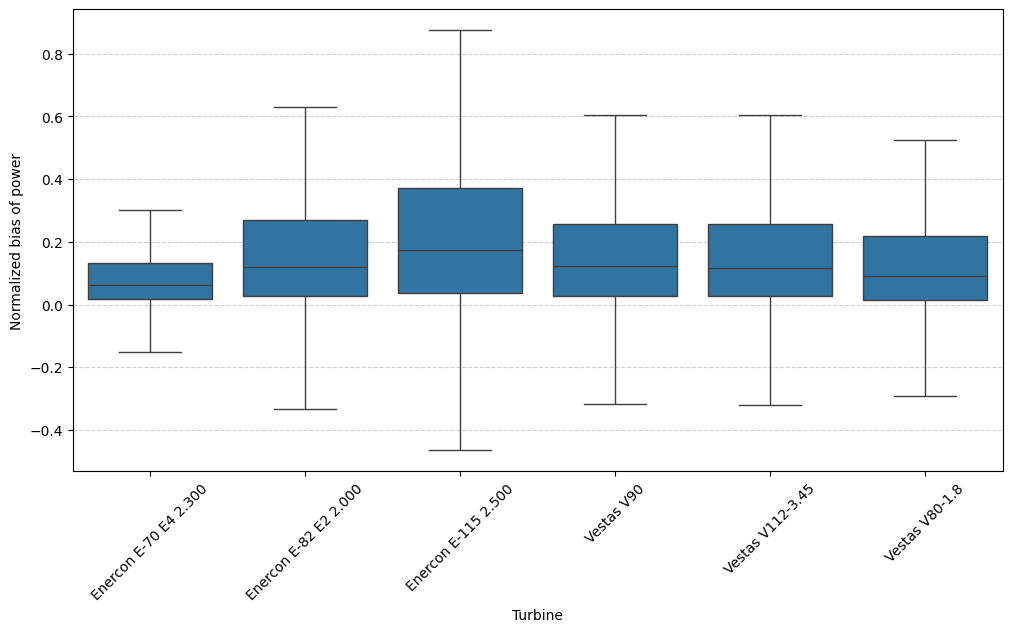

In [10]:
print('Normalized bias of power over all stations for each turbine:')
plot_boxplot_models(power_diffs, ylabel='Normalized bias of power')

Normalized bias of power over all stations per turbine:


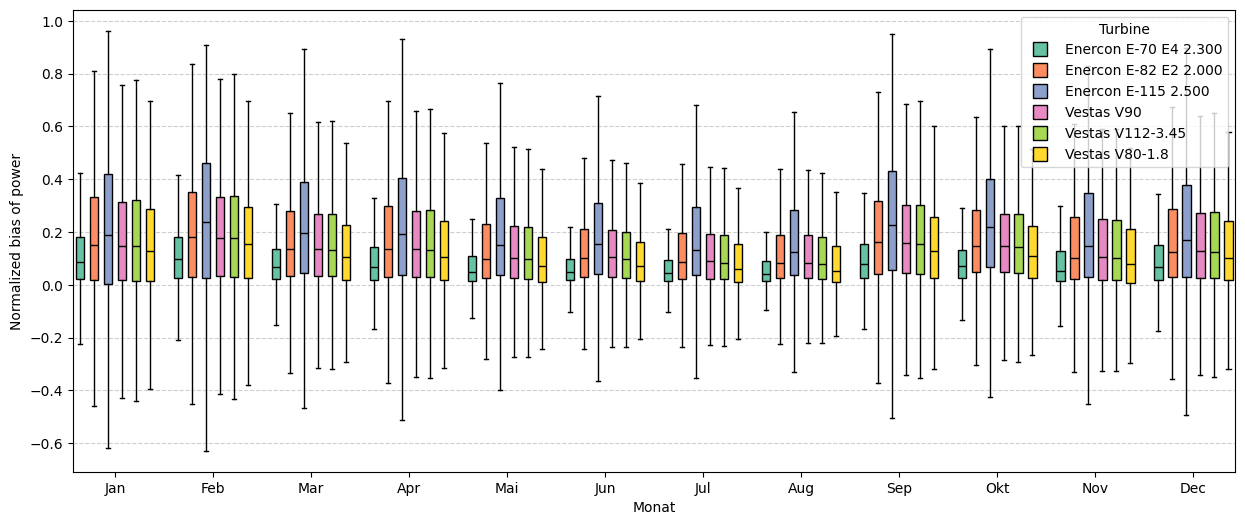

In [11]:
print('Normalized bias of power over all stations per turbine:')
plot_monthly_boxplots(power_diffs, ylabel='Normalized bias of power')

Normalized bias of power over all stations in average for all turbines:


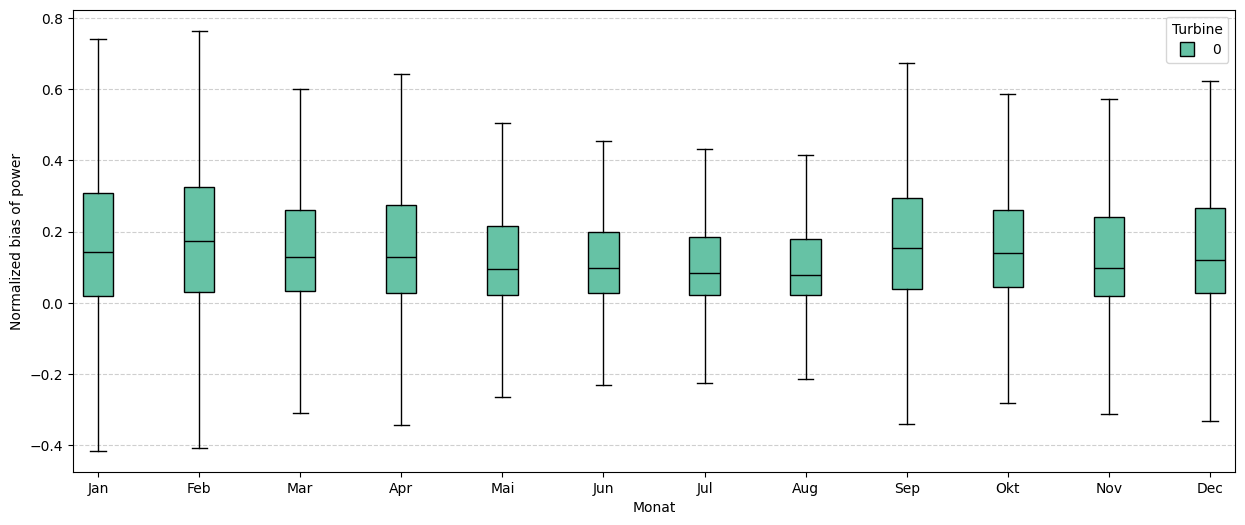

In [12]:
print('Normalized bias of power over all stations in average for all turbines:')
plot_monthly_boxplots(power_diffs.mean(axis=1).to_frame(), ylabel='Normalized bias of power')

Bias of wind speed over all stations per turbine:


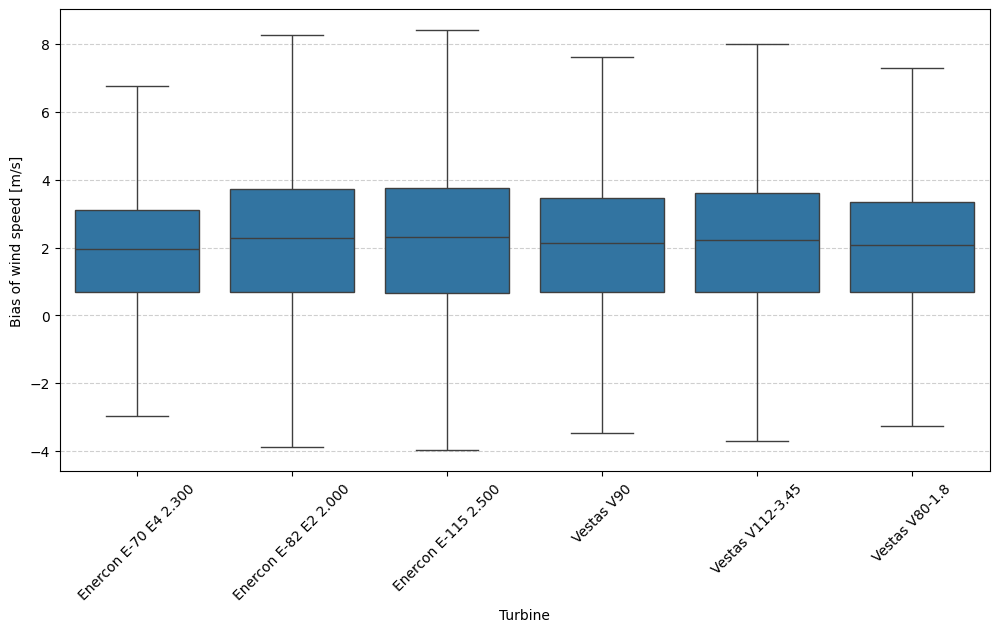

In [13]:
print('Bias of wind speed over all stations per turbine:')
plot_boxplot_models(wind_diffs, ylabel='Bias of wind speed [m/s]')

Bias of wind speed over all stations per turbine.


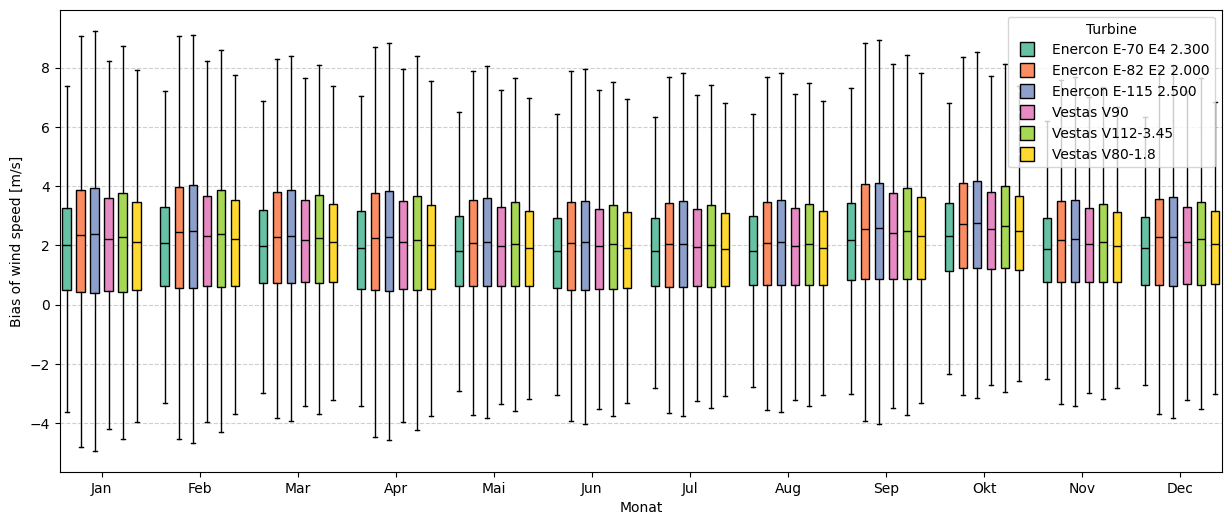

In [14]:
print('Bias of wind speed over all stations per turbine.')
plot_monthly_boxplots(wind_diffs, ylabel='Bias of wind speed [m/s]')

Bias of wind speed over all stations in average for all turbines.


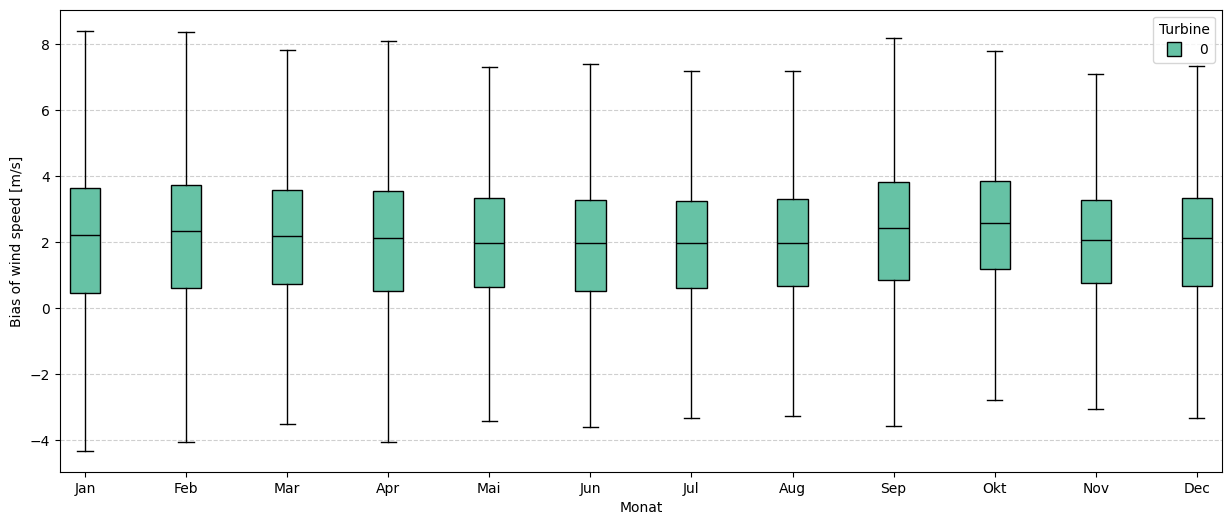

In [15]:
print('Bias of wind speed over all stations in average for all turbines.')
plot_monthly_boxplots(wind_diffs.mean(axis=1).to_frame(), ylabel='Bias of wind speed [m/s]')

In [ ]:
diffs_wind_and_temp = defaultdict(list)
for n, df in enumerate(dfs):
    from_index = n*len(df)
    to_index = len(df)*(n+1)
    for turbine in map(str, range(1, 7)):
        height = turbine_params.iloc[int(turbine)-1]['height']
        wind_diff_batch = wind_diffs[from_index:to_index][wind_diffs.columns[int(turbine)-1]]
        diffs_wind_and_temp['wind_speed_hub'].extend(df[f'wind_speed_t{turbine}'])
        diffs_wind_and_temp['temperature_hub'].extend(df[f'temperature_t{turbine}'])
        diffs_wind_and_temp['density_hub'].extend(df[f'density_t{turbine}'])
        diffs_wind_and_temp['bias'].extend(wind_diff_batch)
        diffs_wind_and_temp['timestamp'].extend(wind_diff_batch.index)
        diffs_wind_and_temp['height'].extend(np.ones(len(wind_diff_batch)) * height)
df_diffs_and_temp = pd.DataFrame(diffs_wind_and_temp)
df_diffs_and_temp.set_index('timestamp', inplace=True)
df_diffs_and_temp['wind_speed_bin'] = df_diffs_and_temp['wind_speed_hub'].apply(lambda x: round(x / 5) * 5)

In [77]:
diffs_10m = pd.read_csv('results/wind_diffs_and_weather_10m.csv')
diffs_10m['timestamp'] = pd.to_datetime(diffs_10m['timestamp'], utc=True)
diffs_10m.set_index('timestamp', inplace=True)

In [99]:
mean_bias_10m = diffs_10m.groupby('timestamp').mean()['bias']
mean_bias_hub = df_diffs_and_temp.groupby('timestamp').mean()['bias']
mean_wind_speed_hub = df_diffs_and_temp.groupby('timestamp').mean()['wind_speed_hub']
mean_temp_hub = df_diffs_and_temp.groupby('timestamp').mean()['temperature_hub']
mean_wind_speed_10m = diffs_10m.groupby('timestamp').mean()['wind_speed']
mean_temp_2m = diffs_10m.groupby('timestamp').mean()['temperature_2m']

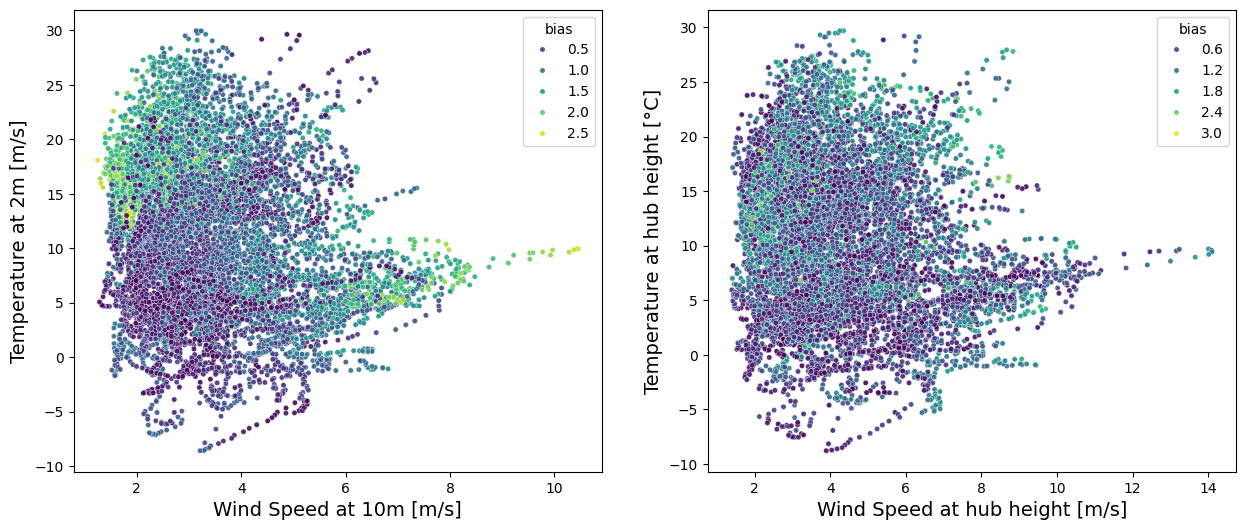

In [117]:
scaled_bias_hub = (mean_bias_hub - mean_bias_hub.mean()) / mean_bias_hub.std()
scaled_bias_10m = (mean_bias_10m - mean_bias_10m.mean()) / mean_bias_10m.std()

fontsize = 14
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(x=mean_wind_speed_hub,
                y=mean_temp_hub,
                hue=scaled_bias_hub.abs(),
                palette='viridis',
                s=15,
                alpha=0.9,
                ax=axes[1])
sns.scatterplot(x=mean_wind_speed_10m,
                y=mean_temp_2m,
                hue=scaled_bias_10m.abs(),
                palette='viridis',
                s=15,
                alpha=0.9,
                ax=axes[0])
axes[1].set_xlabel('Wind Speed at hub height [m/s]', fontsize=fontsize)
axes[1].set_ylabel('Temperature at hub height [°C]', fontsize=fontsize)
axes[0].set_xlabel('Wind Speed at 10m [m/s]', fontsize=fontsize)
axes[0].set_ylabel('Temperature at 2m [m/s]', fontsize=fontsize)
plt.show()

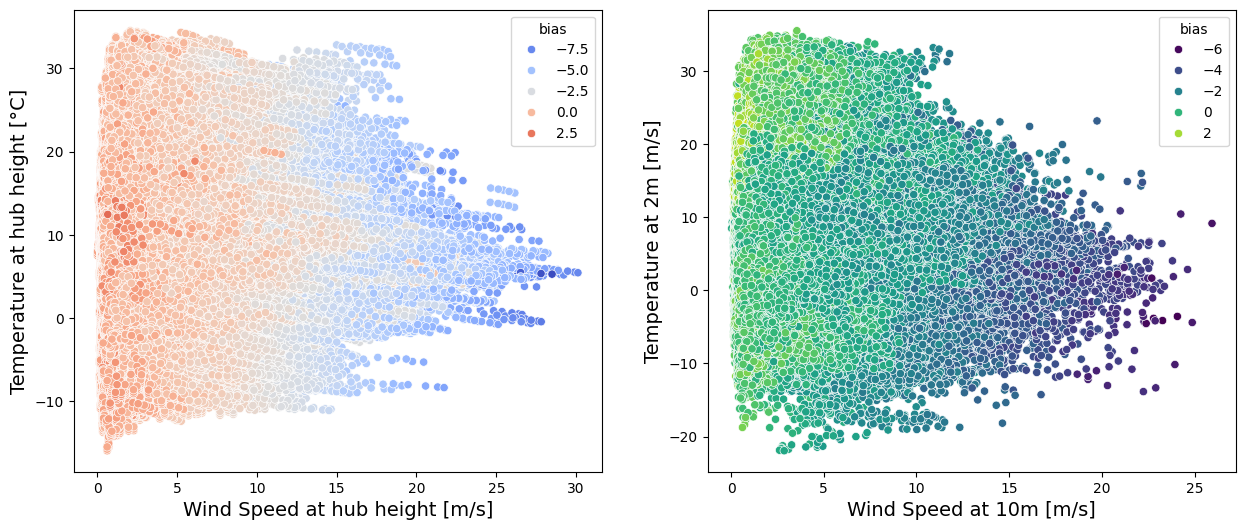

In [ ]:
scaled_bias_hub = (df_diffs_and_temp['bias'] - df_diffs_and_temp['bias'].mean()) / df_diffs_and_temp['bias'].std()
scaled_bias_10m = (diffs_10m['bias'] - diffs_10m['bias'].mean()) / diffs_10m['bias'].std()

fontsize = 14
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(data=df_diffs_and_temp,
                x='wind_speed_hub',
                y='temperature_hub',
                hue=scaled_bias_hub,
                palette='coolwarm',
                #alpha=0.1,
                ax=axes[1])
sns.scatterplot(data=diffs_10m,
                x='wind_speed',
                y='temperature_2m',
                hue=scaled_bias_10m,
                palette='viridis',
                #alpha=0.1,
                ax=axes[0])
axes[1].set_xlabel('Wind Speed at hub height [m/s]', fontsize=fontsize)
axes[1].set_ylabel('Temperature at hub height [°C]', fontsize=fontsize)
axes[0].set_xlabel('Wind Speed at 10m [m/s]', fontsize=fontsize)
axes[0].set_ylabel('Temperature at 2m [m/s]', fontsize=fontsize)
plt.show()

Text(0, 0.5, 'Bias in wind speed on hub height')

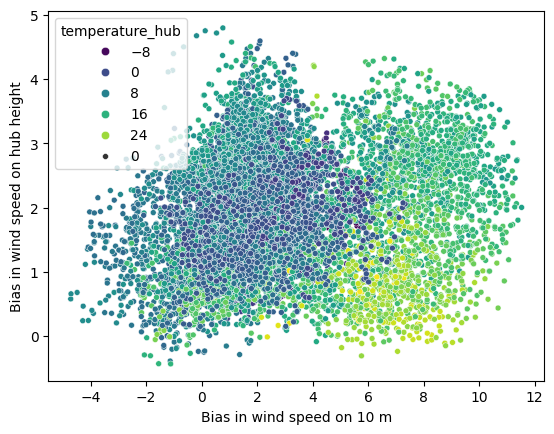

In [96]:
sns.scatterplot(x=mean_bias_10m, y=mean_bias_hub, hue=mean_temp_hub, size=0, palette='viridis')
plt.xlabel('Bias in wind speed on 10 m')
plt.ylabel('Bias in wind speed on hub height')

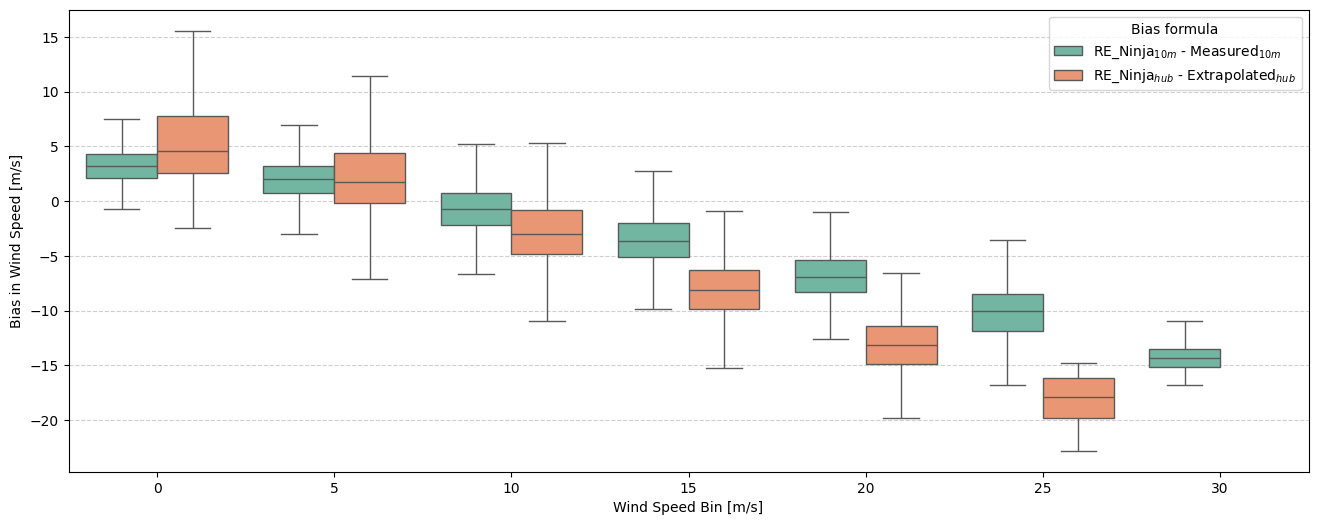

In [357]:
label_1 = 'RE_Ninja$_{10m}$ - Measured$_{10m}$'
label_2 = 'RE_Ninja$_{hub}$ - Extrapolated$_{hub}$'
plot_wind_speed_boxplots(df1=df_diffs_and_temp, df2=diffs_10m, labels=(label_1, label_2))

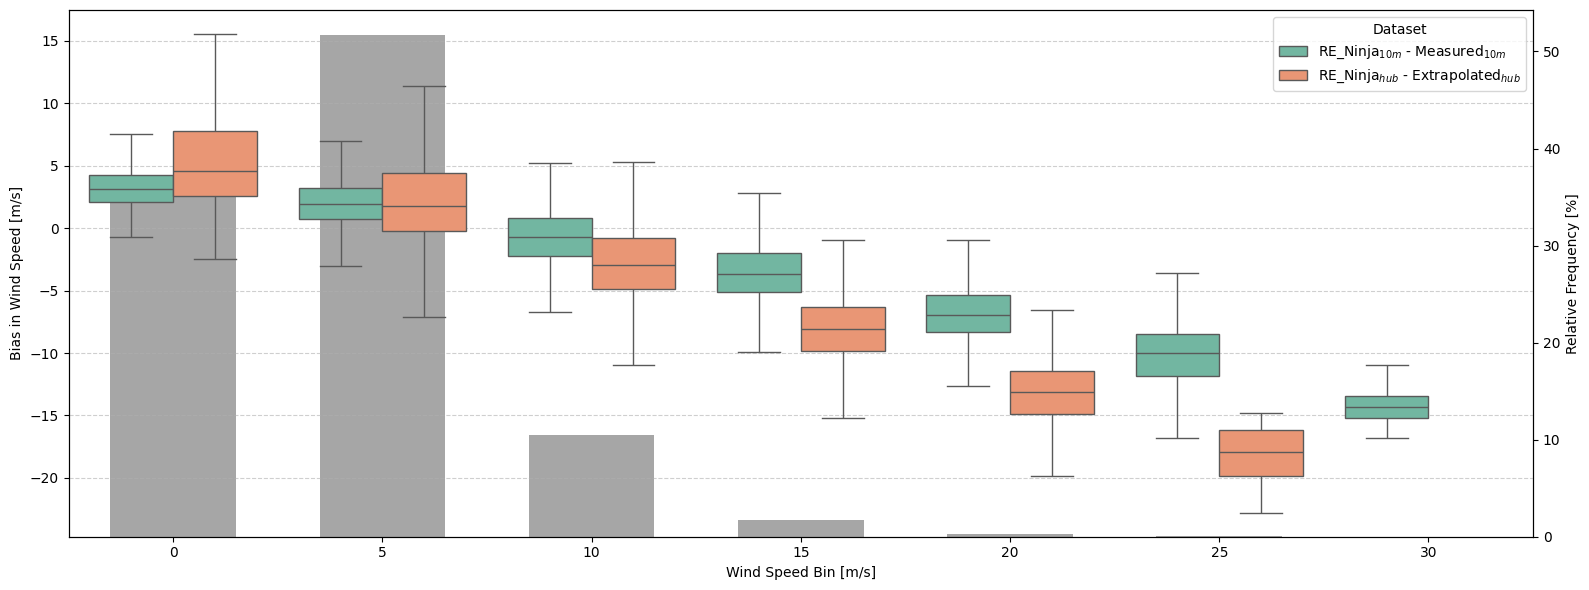

In [368]:
plot_wind_speed_boxplot_with_density(df1=df_diffs_and_temp, df2=diffs_10m, labels=(label_1, label_2))

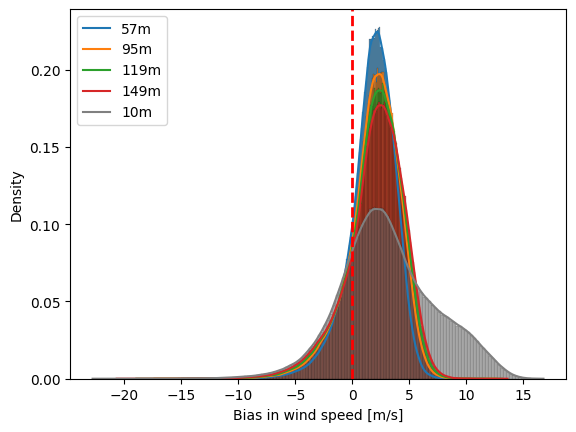

In [349]:
heights = [57, 95, 119, 149]
for height in heights:
    df_diffs_height = df_diffs_and_temp.loc[df_diffs_and_temp.height == height]
    sns.histplot(df_diffs_height.bias, stat='density', alpha=0.7, bins=300, kde=True, label=f'{int(height)}m')
sns.histplot(diffs_10m.bias, stat='density', alpha=0.5, bins=300, kde=True, label='10m', color='grey')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Bias in wind speed [m/s]')
heights.append(10)
heights = [f'{h}m' for h in heights]
plt.legend(heights, loc='upper left')
plt.show()

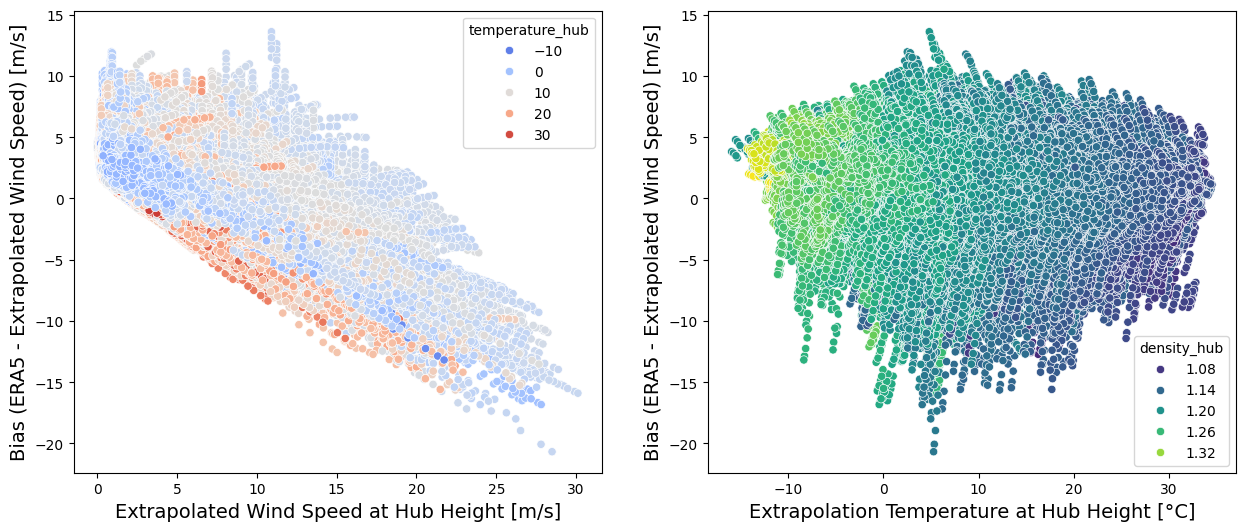

In [18]:
label = 'Extrapolation Temperature at Hub Height [°C]'
plot_scatter_wind(data=df_diffs_and_temp, x='temperature_hub', hue='density_hub', label=label)

In [19]:
hours_in_2024 = 8784
plots_target_dir = 'results/scatterplot_temp'
label = 'Extrapolation Temperature at Hub Height [°C]'
os.makedirs(plots_target_dir, exist_ok=True)
file_names = iter(station_files_synthetic)
turbine_counter = 1
station_id = next(file_names).split('.')[0][-5:]
for index in range(len(df_diffs_and_temp)//hours_in_2024):
    if turbine_counter == 7:
        turbine_counter = 1
        station_id = next(file_names).split('.')[0][-5:]
    df_year = df_diffs_and_temp[index*hours_in_2024:hours_in_2024*(index+1)]
    save_path = os.path.join(plots_target_dir, f'scatter_{station_id}_t{turbine_counter}')
    plot_scatter_wind(data=df_year, x='temperature_hub', hue='density_hub', label=label, save_path=save_path)
    turbine_counter += 1

/Users/viktorwalter/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


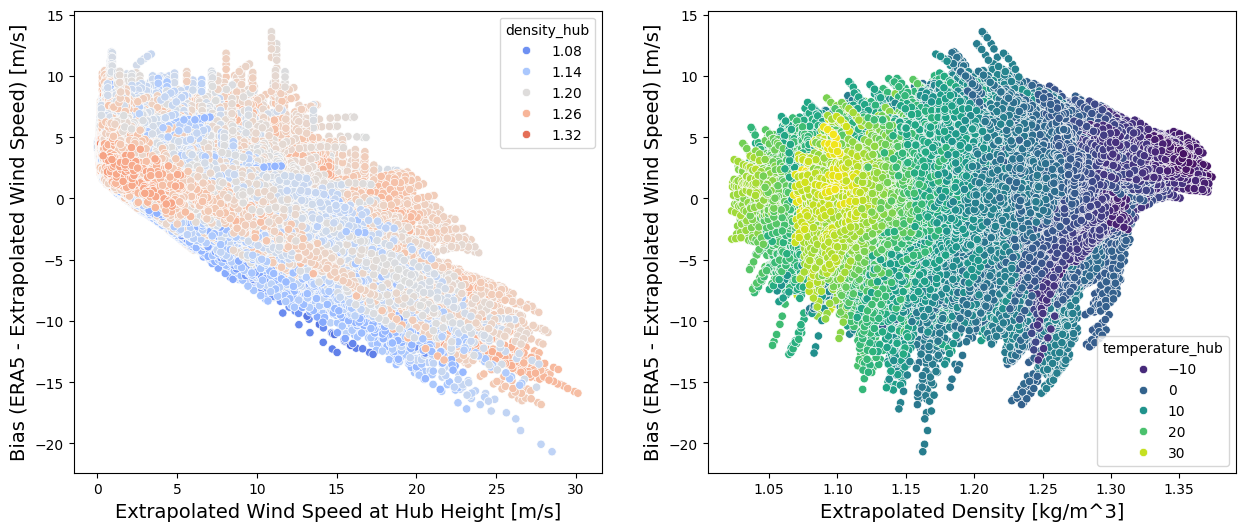

In [20]:
label = 'Extrapolated Density [kg/m^3]'
plot_scatter_wind(data=df_diffs_and_temp, x='density_hub', hue='temperature_hub', label=label)

In [21]:
hours_in_2024 = 8784
plots_target_dir = 'results/scatterplot_density'
label = 'Extrapolation Density at Hub Height [°C]'
os.makedirs(plots_target_dir, exist_ok=True)
file_names = iter(station_files_synthetic)
turbine_counter = 1
station_id = next(file_names).split('.')[0][-5:]
for index in range(len(df_diffs_and_temp)//hours_in_2024):
    if turbine_counter == 7:
        turbine_counter = 1
        station_id = next(file_names).split('.')[0][-5:]
    df_year = df_diffs_and_temp[index*hours_in_2024:hours_in_2024*(index+1)]
    save_path = os.path.join(plots_target_dir, f'scatter_{station_id}_t{turbine_counter}')
    plot_scatter_wind(data=df_year, x='density_hub', hue='temperature_hub', label=label, save_path=save_path)
    turbine_counter += 1

In [22]:
results = pd.read_csv(os.path.join(results_dir, 'comparison_in_GWh.csv'))
results.set_index('station_id', inplace=True)
clean_names = results.columns.str.replace(r"^(synthetic |re\.ninja )", "", regex=True)
unique_turbines = clean_names.unique()

In [303]:
# get differences
diff_matrix_abs = []
diff_matrix = []
for index, row in results.iterrows():
    abs_rows = []
    rows = []
    for turbine_nr in range(int(len(row.index)/2)):
        two_cols = row.iloc[turbine_nr*2:turbine_nr*2+2]
        synthetic_value = two_cols.iloc[0]
        re_ninja_value = two_cols.iloc[1]
        abs_diff = abs(re_ninja_value - synthetic_value)
        diff = re_ninja_value - synthetic_value
        abs_rows.append(abs_diff)
        rows.append(diff)
    diff_matrix_abs.append(abs_rows)
    diff_matrix.append(rows)
df_diff_abs = pd.DataFrame(diff_matrix_abs, columns=unique_turbines, index=results.index)
df_diff = pd.DataFrame(diff_matrix, columns=unique_turbines, index=results.index)

NameError: name 'results' is not defined

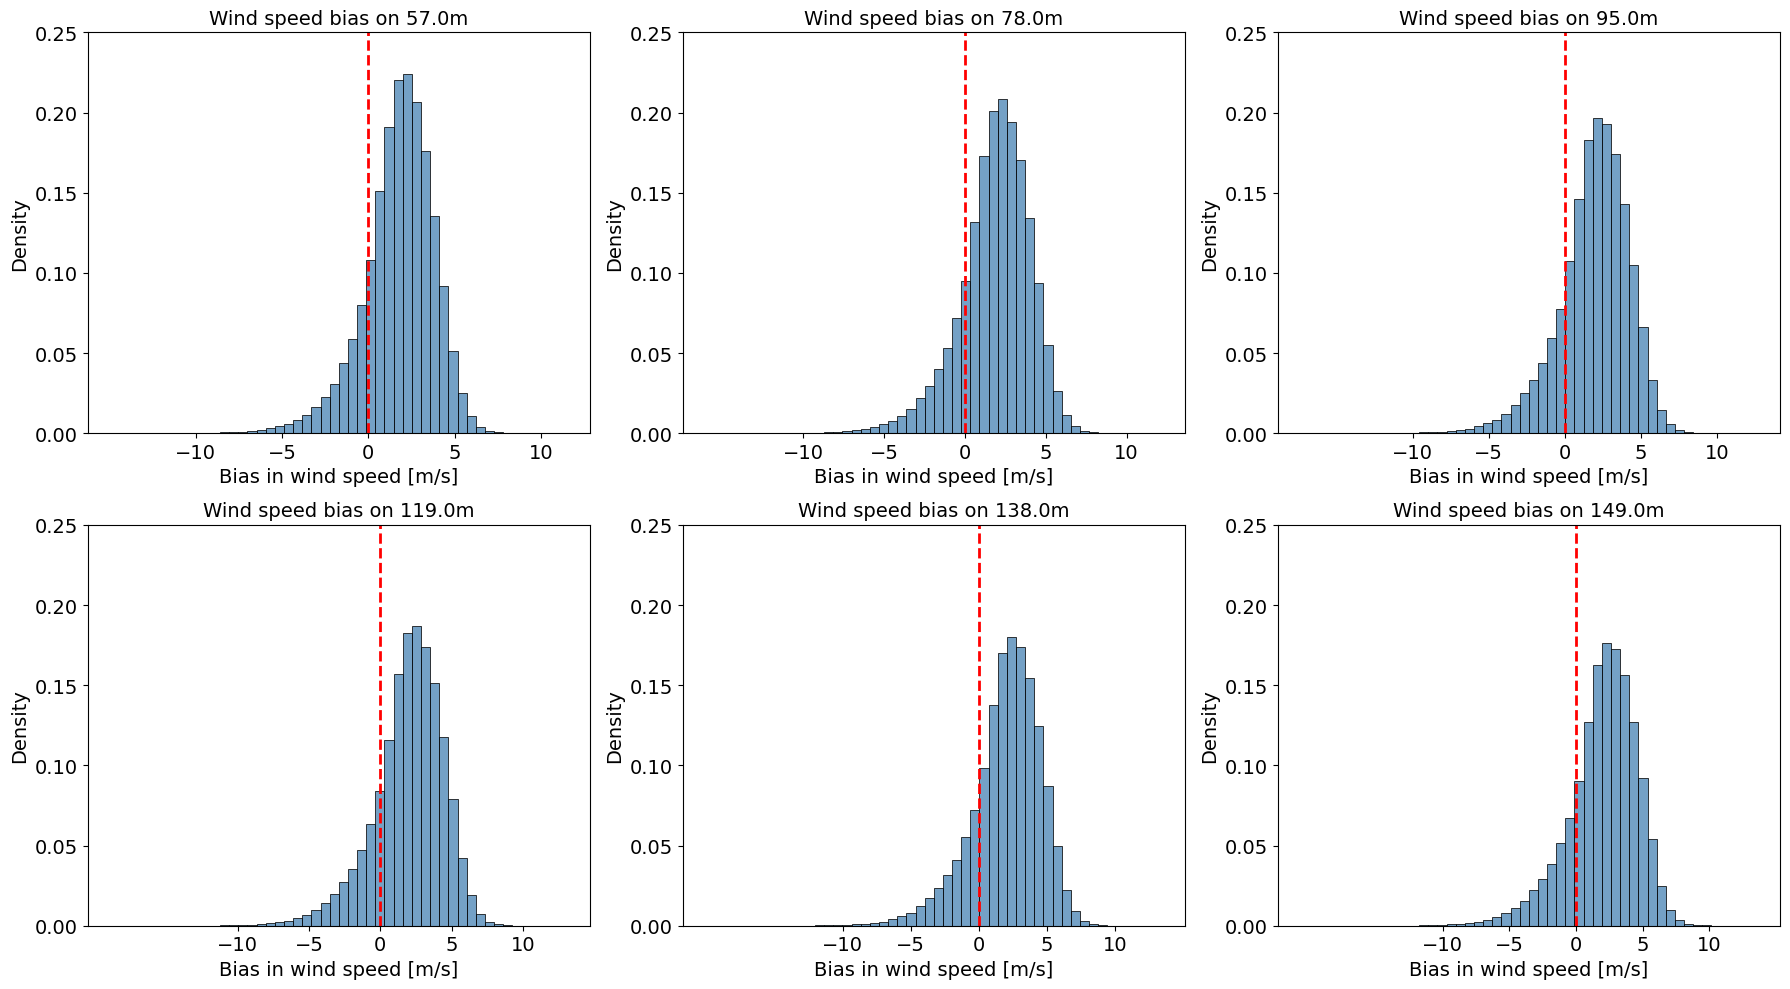

In [353]:
heights = np.sort(df_diffs_and_temp.height.unique()).tolist()
col_list = turbine_params.sort_values('height')['turbine'].to_list()
heights = [f'Wind speed bias on {h}m' for h in heights]
xticks = np.arange(-10,15,5)
yticks = np.arange(0,0.3,0.05)
plot_turbine_histograms(wind_diffs,
                        xlabel='Bias in wind speed [m/s]',
                        col_list=col_list,
                        bins=50,
                        title_list=heights,
                        xticks=xticks,
                        yticks=yticks)

In [198]:
data_a, data_b = dfs[0], val_dfs[0]
for df, val_df in zip(dfs[1:], val_dfs[1:]):
    data_a = pd.concat([data_a, df], axis=0)
    data_b = pd.concat([data_b, val_df], axis=0)

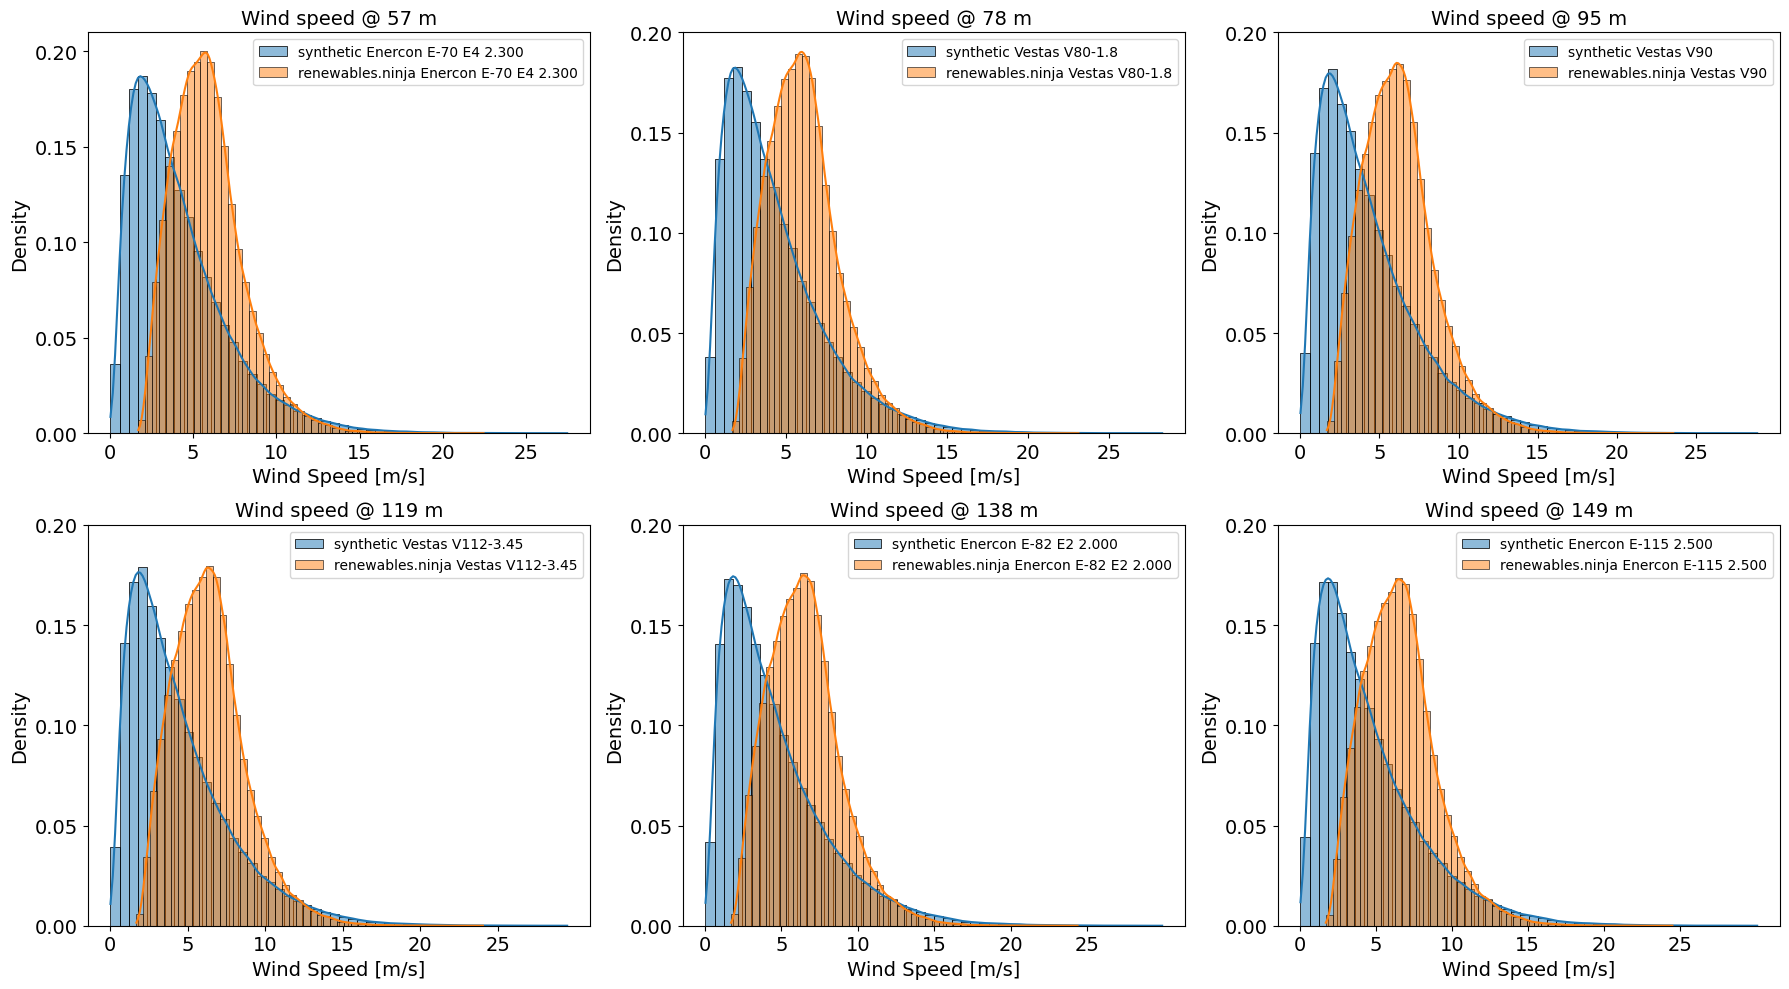

In [ ]:
index_list = turbine_params.height.sort_values().index.to_list()
index_list = [i+1 for i in index_list]
order = map(str, index_list)
xticks = np.arange(0,30,5)
yticks = np.arange(0,0.25,0.05)
plot_wind_speed_distribution(data_a=data_a,
                             data_b=data_b,
                             order=order,
                             xticks=xticks,
                             yticks=yticks,
                             mapping=mapping,
                             turbine_mapping=turbine_mapping,
                             specs=specs)

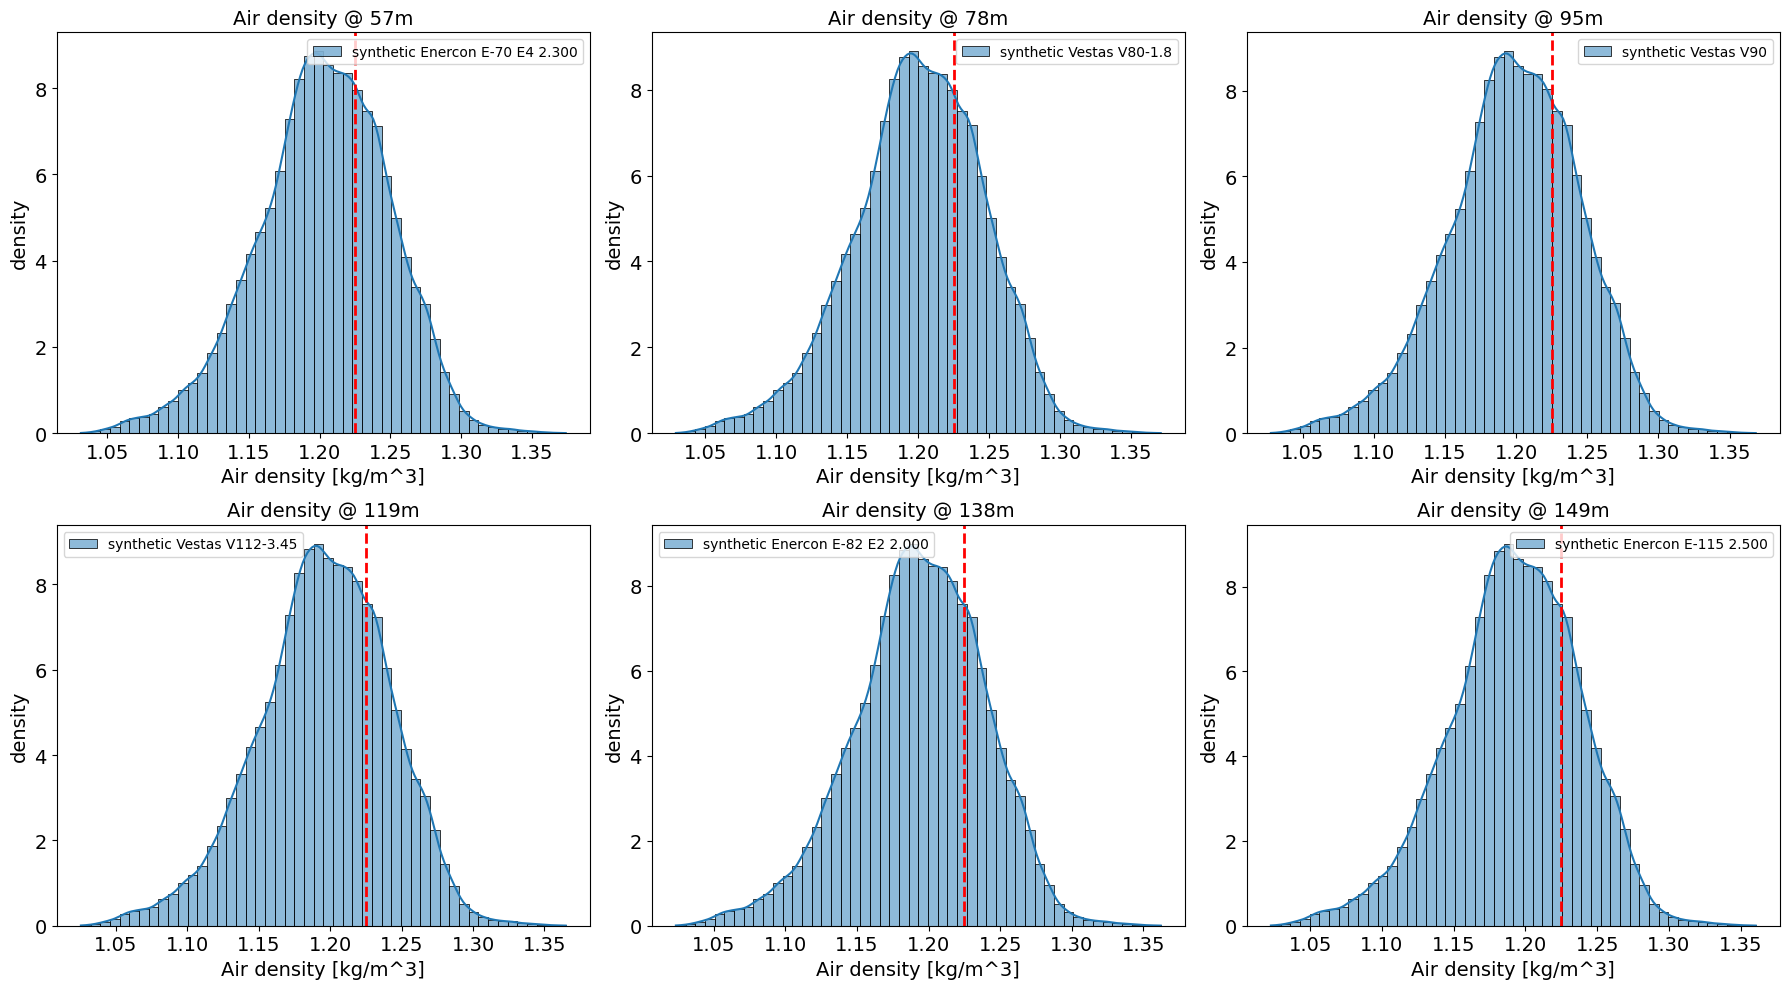

In [352]:
index_list = turbine_params.height.sort_values().index.to_list()
index_list = [i+1 for i in index_list]
order = map(str, index_list)
plot_density_distribution(data_a=data_a,
                            order=order,
                            bins=50,
                            #xticks=xticks,
                            #yticks=yticks,
                            mapping=mapping,
                            turbine_mapping=turbine_mapping,
                            specs=specs)

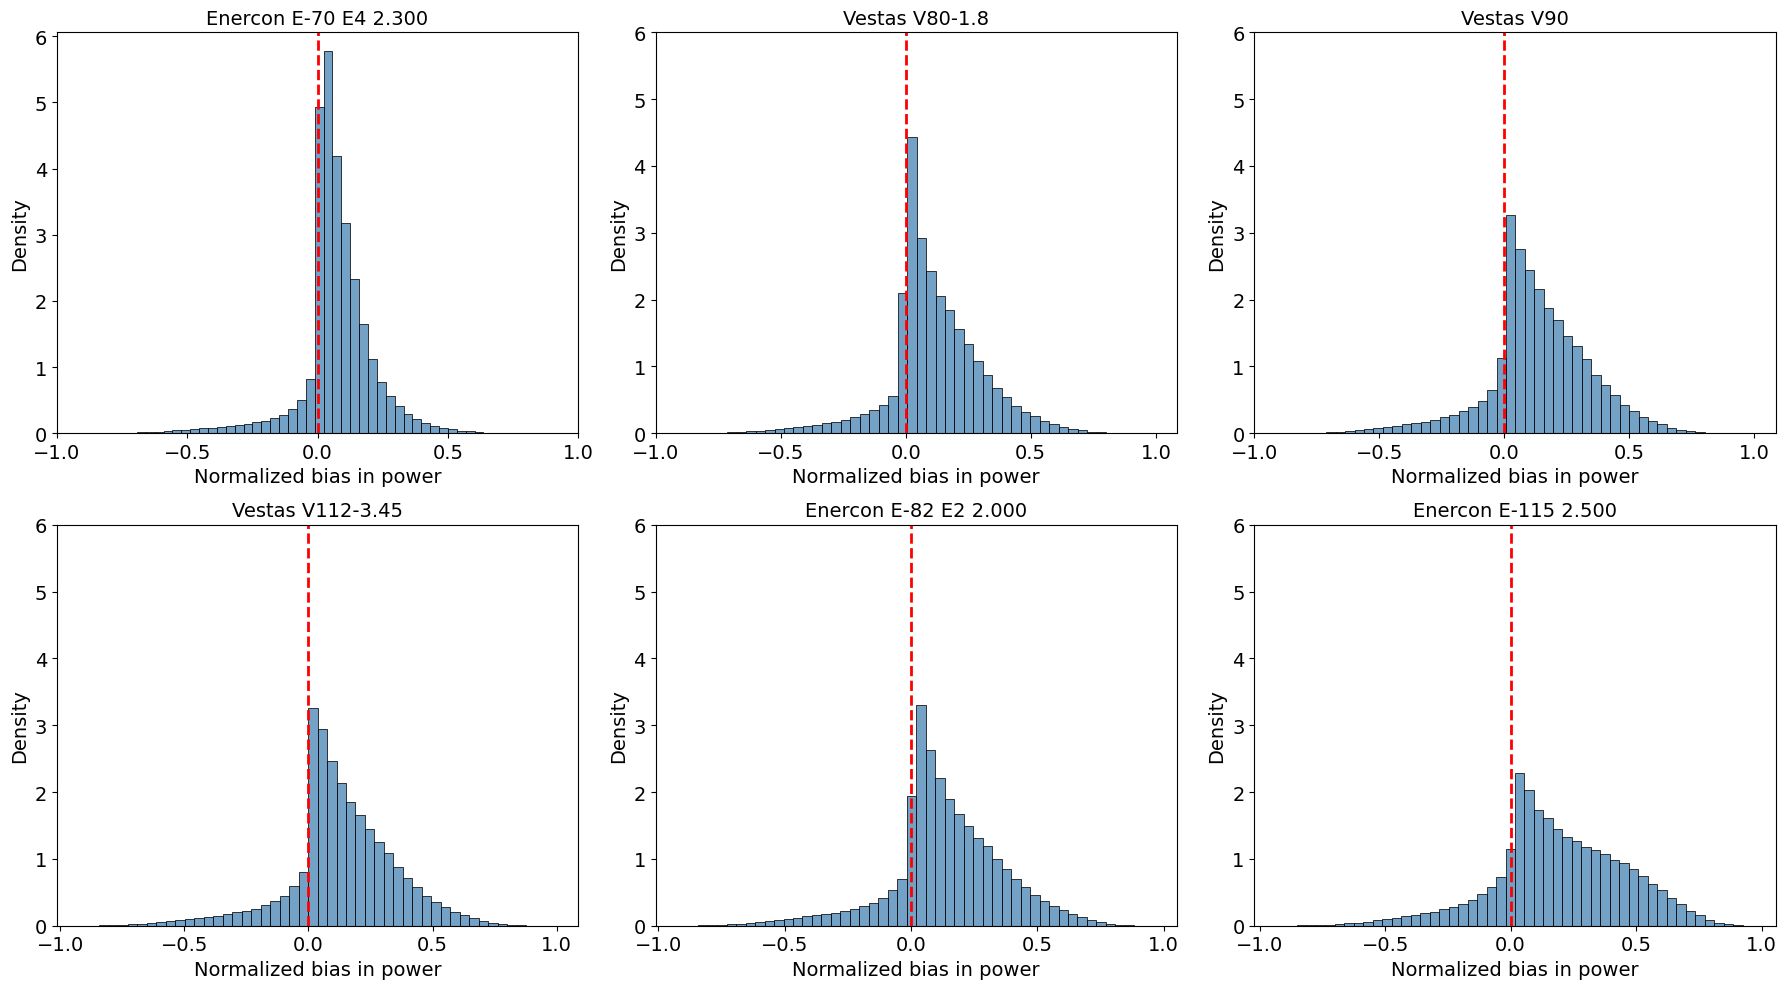

In [351]:
xticks = np.arange(-1,1.1,0.5)
yticks = np.arange(0,7,1)
plot_turbine_histograms(power_diffs, col_list=col_list, xticks=xticks, bins=50, yticks=yticks, xlabel='Normalized bias in power')

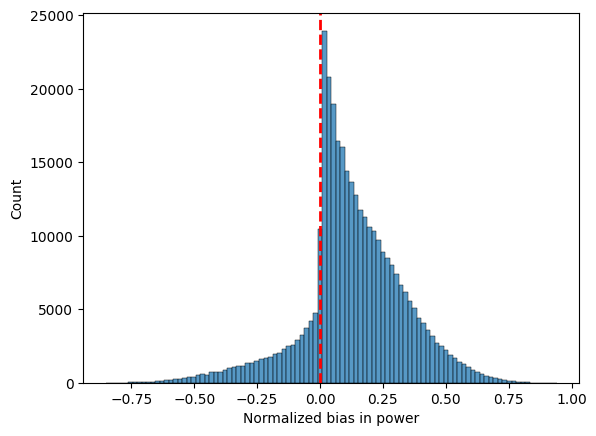

In [ ]:
sns.histplot(power_diffs.mean(axis=1), bins=100)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
#plt.title('Difference renewables.ninja to synthetic over all turbines and locations')
plt.xlabel('Normalized bias in power')
plt.show()

In [ ]:
stats, power_diffs, wind_diffs = get_stats_and_diffs(data_a, data_b, mapping, turbine_mapping)

Turbine Enercon E-70 E4 2.300:
Synthetic energy: 70.89 GWh
Renewables.ninja energy: 127.12 GWh

Turbine Enercon E-82 E2 2.000:
Synthetic energy: 109.42 GWh
Renewables.ninja energy: 203.63 GWh

Turbine Enercon E-115 2.500:
Synthetic energy: 176.64 GWh
Renewables.ninja energy: 339.45 GWh

Turbine Vestas V90:
Synthetic energy: 102.44 GWh
Renewables.ninja energy: 194.64 GWh

Turbine Vestas V112-3.45:
Synthetic energy: 178.73 GWh
Renewables.ninja energy: 335.20 GWh

Turbine Vestas V80-1.8:
Synthetic energy: 74.19 GWh
Renewables.ninja energy: 144.74 GWh

Total synthetic energy: 712.32 GWh
Total renewables.ninja energy: 1344.78 GWh


In [26]:
# show results for specific station locations
station_id = '00164'
not_found = False
for idx, file in enumerate(station_files_synthetic):
    if station_id in file:
        not_found = True
        break
if not_found:
    nr = idx
else:
    print(f'Station {station_id} not found.')

In [27]:
print(f'Wind farm commissioned on {wind_params.loc[wind_params['park_id'] == station_id]['commissioning_date'].iloc[0]}')

Wind farm commissioned on -


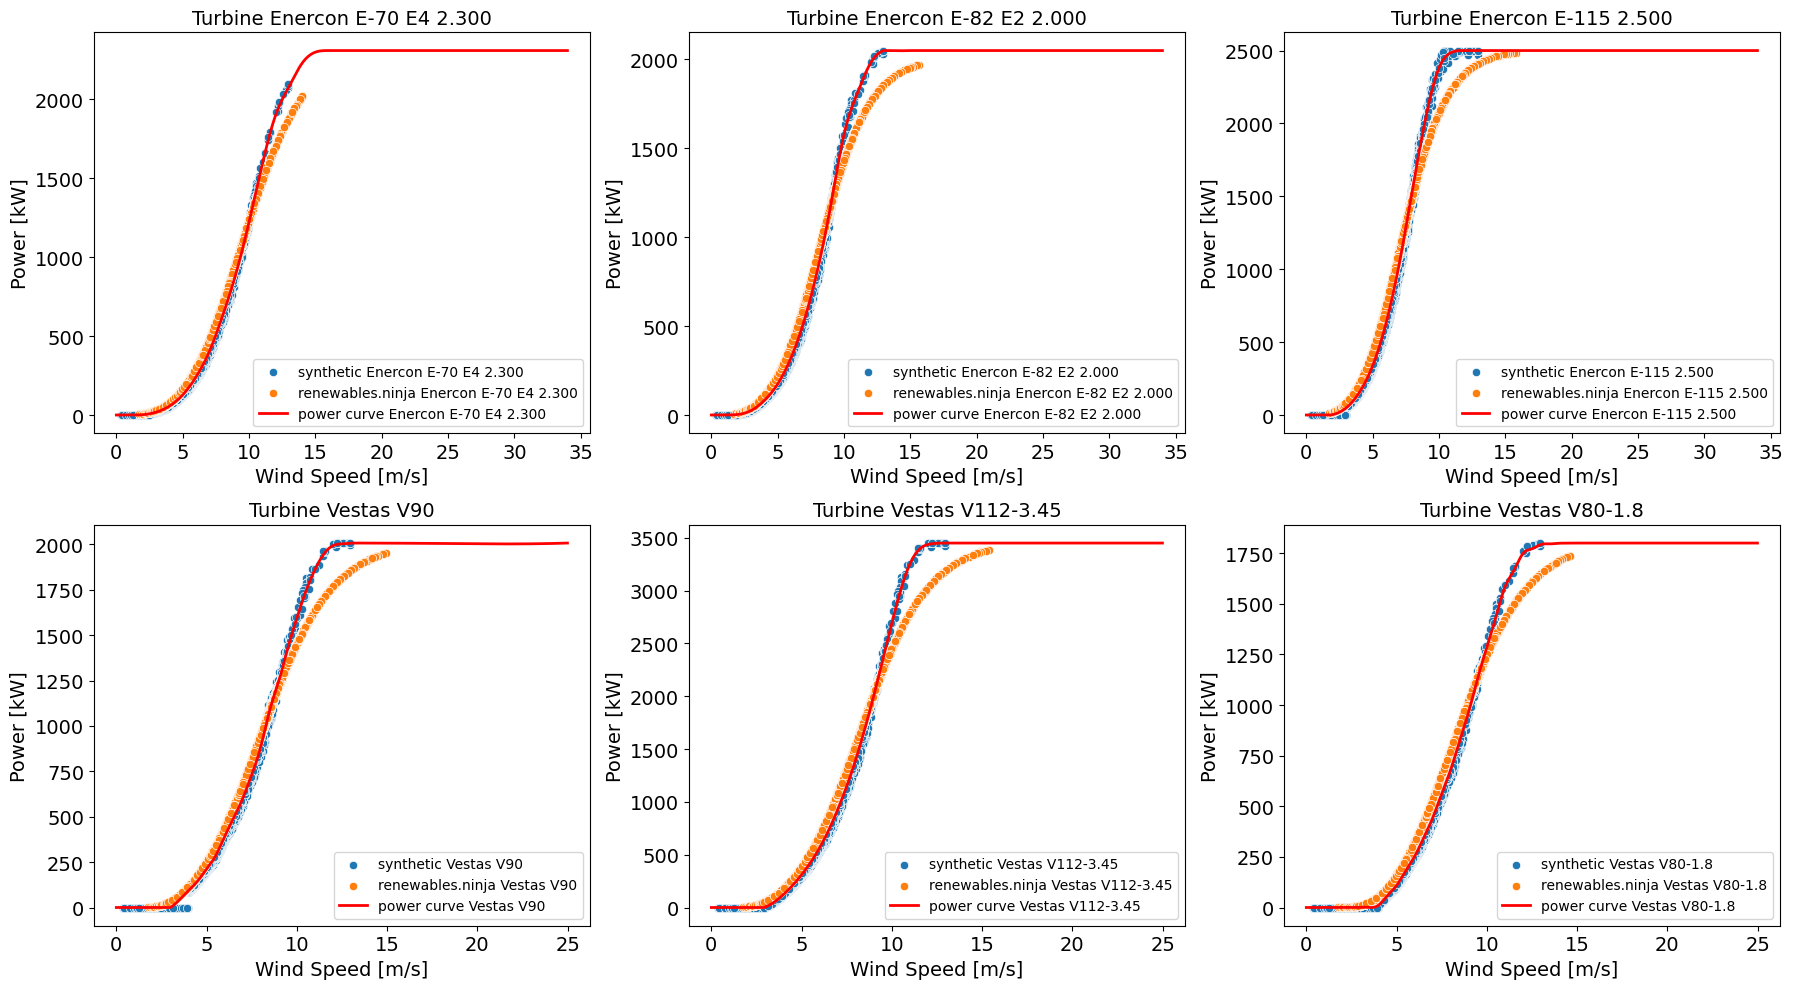

In [28]:
plot_power_curves(dfs[nr], val_dfs[nr], power_curves, mapping, turbine_mapping)

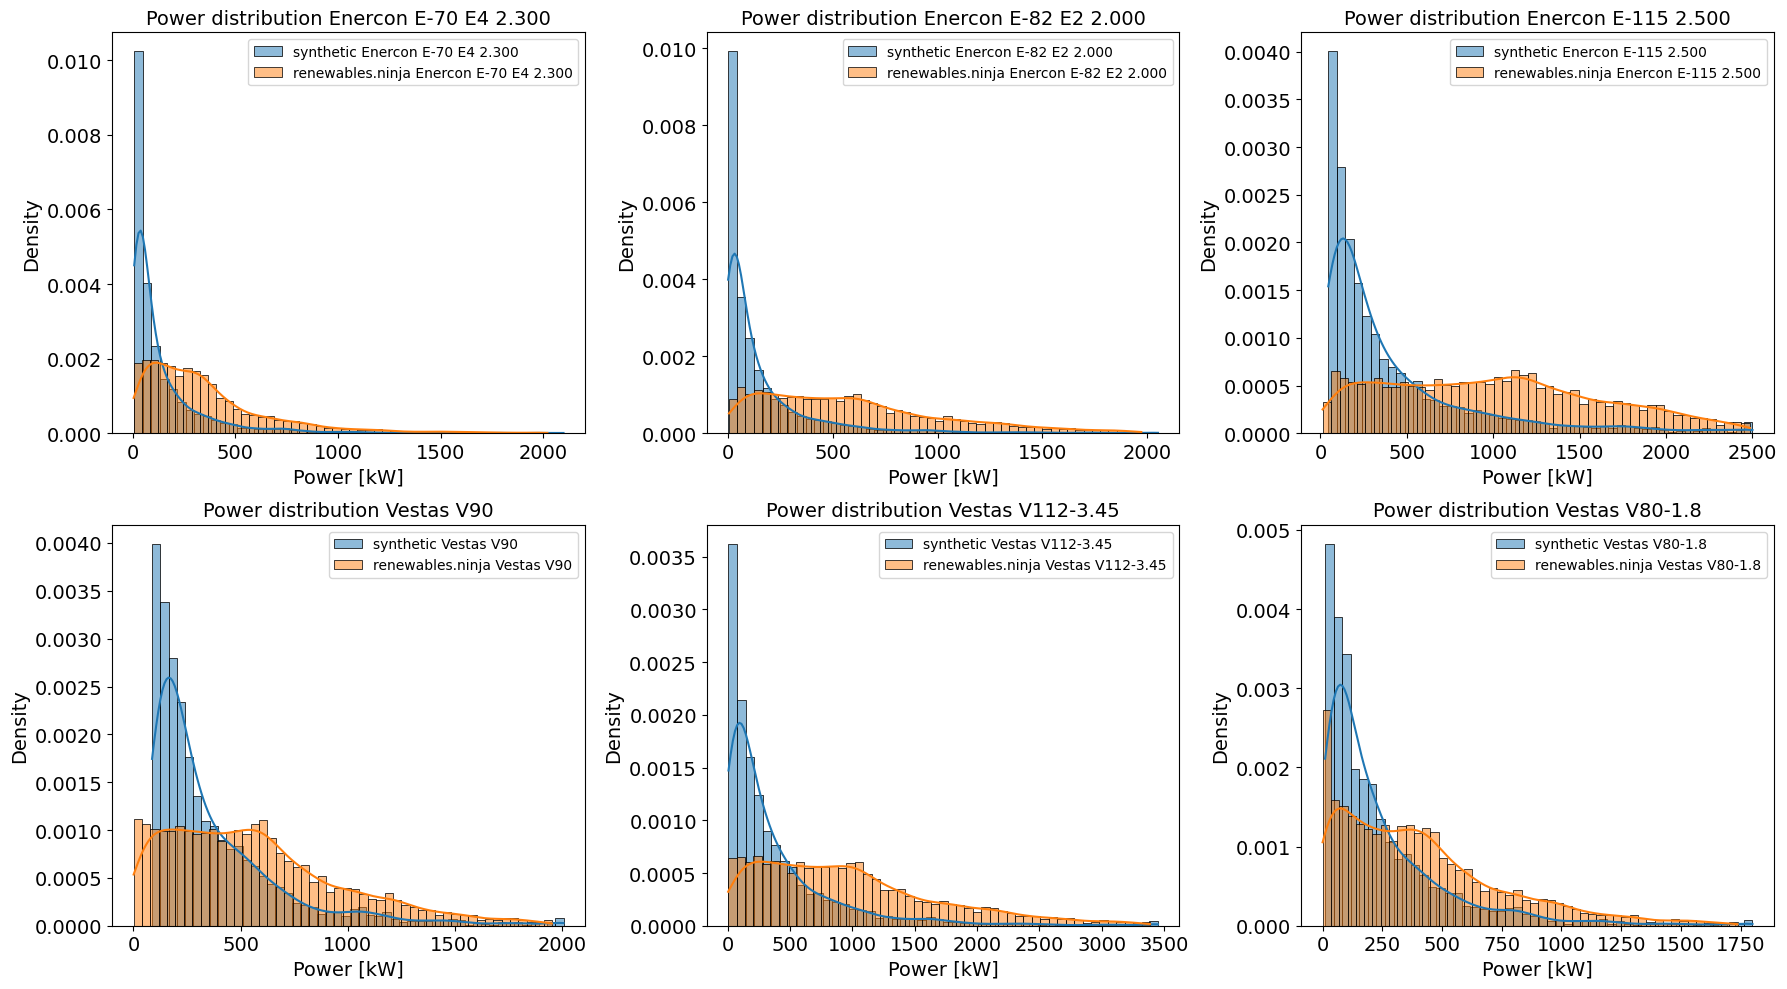

In [29]:
plot_power_distribution(dfs[nr], val_dfs[nr], mapping, turbine_mapping)

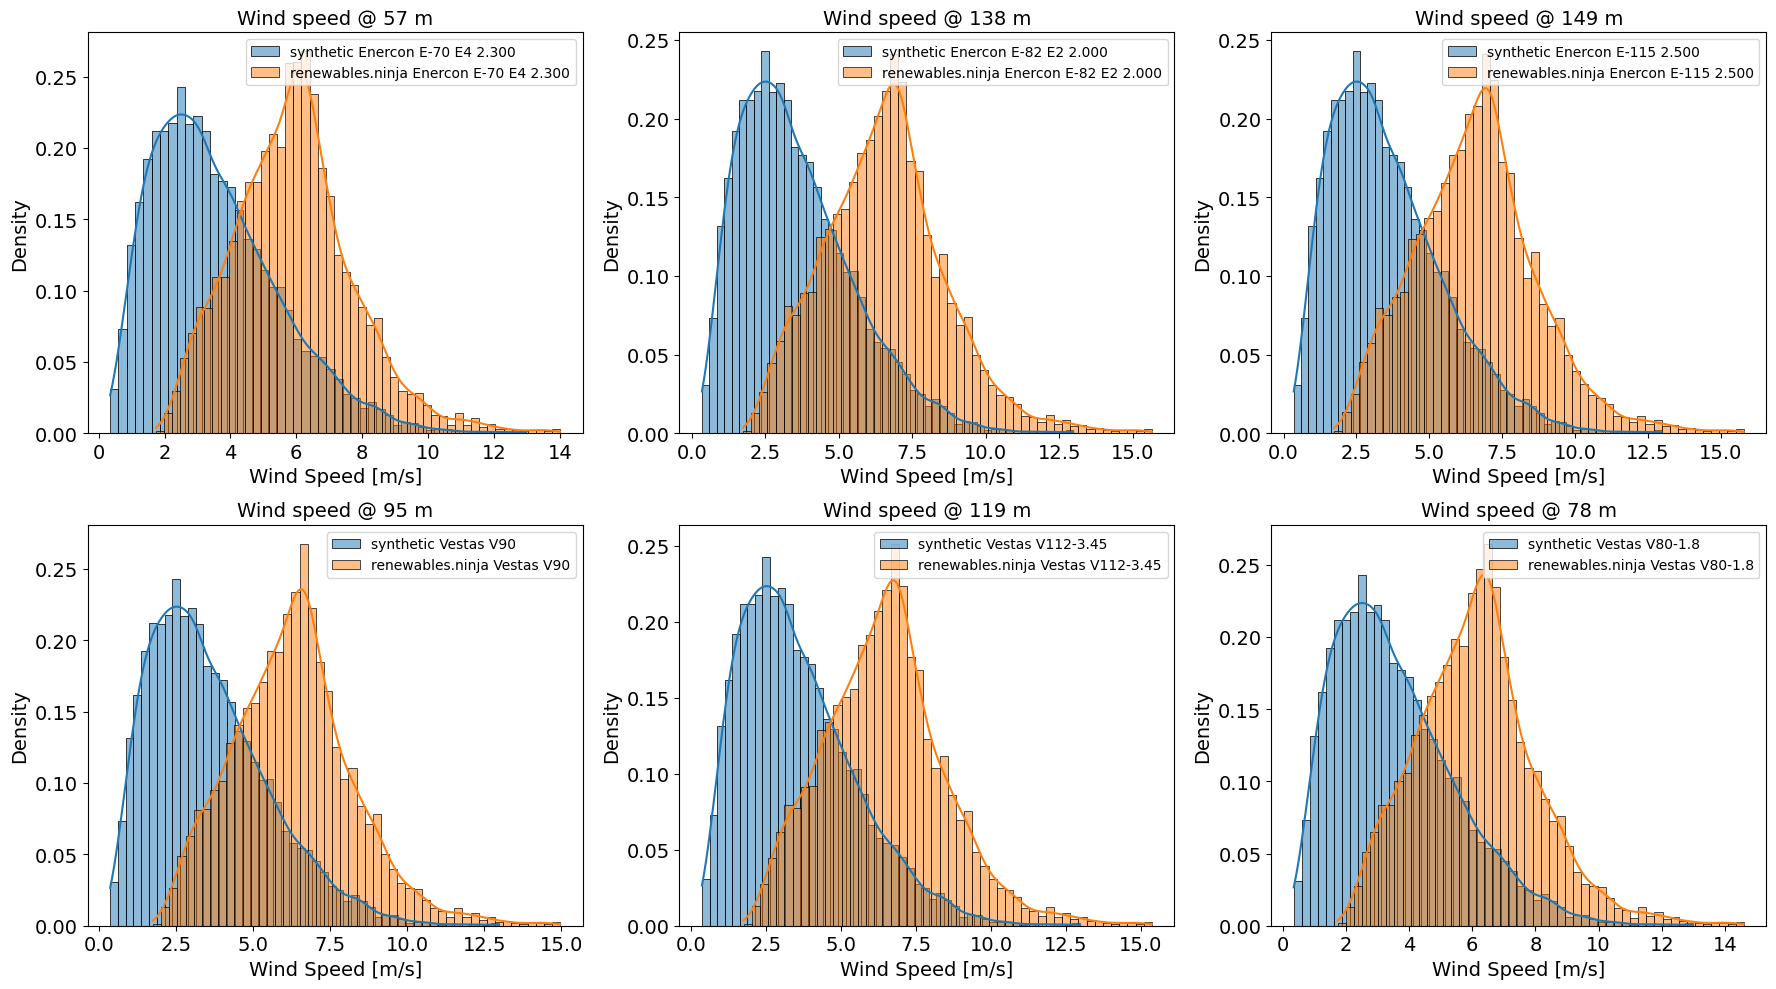

In [30]:
plot_wind_speed_distribution(dfs[nr], val_dfs[nr], mapping, turbine_mapping, specs)

In [31]:
stats, power_diffs, wind_diffs = get_stats_and_diffs(dfs[nr], val_dfs[nr], mapping, turbine_mapping)

Turbine Enercon E-70 E4 2.300:
Synthetic energy: 0.84 GWh
Renewables.ninja energy: 3.12 GWh

Turbine Enercon E-82 E2 2.000:
Synthetic energy: 1.11 GWh
Renewables.ninja energy: 5.21 GWh

Turbine Enercon E-115 2.500:
Synthetic energy: 2.03 GWh
Renewables.ninja energy: 8.87 GWh

Turbine Vestas V90:
Synthetic energy: 1.15 GWh
Renewables.ninja energy: 4.98 GWh

Turbine Vestas V112-3.45:
Synthetic energy: 1.84 GWh
Renewables.ninja energy: 8.56 GWh

Turbine Vestas V80-1.8:
Synthetic energy: 0.77 GWh
Renewables.ninja energy: 3.65 GWh

Total synthetic energy: 7.74 GWh
Total renewables.ninja energy: 34.38 GWh


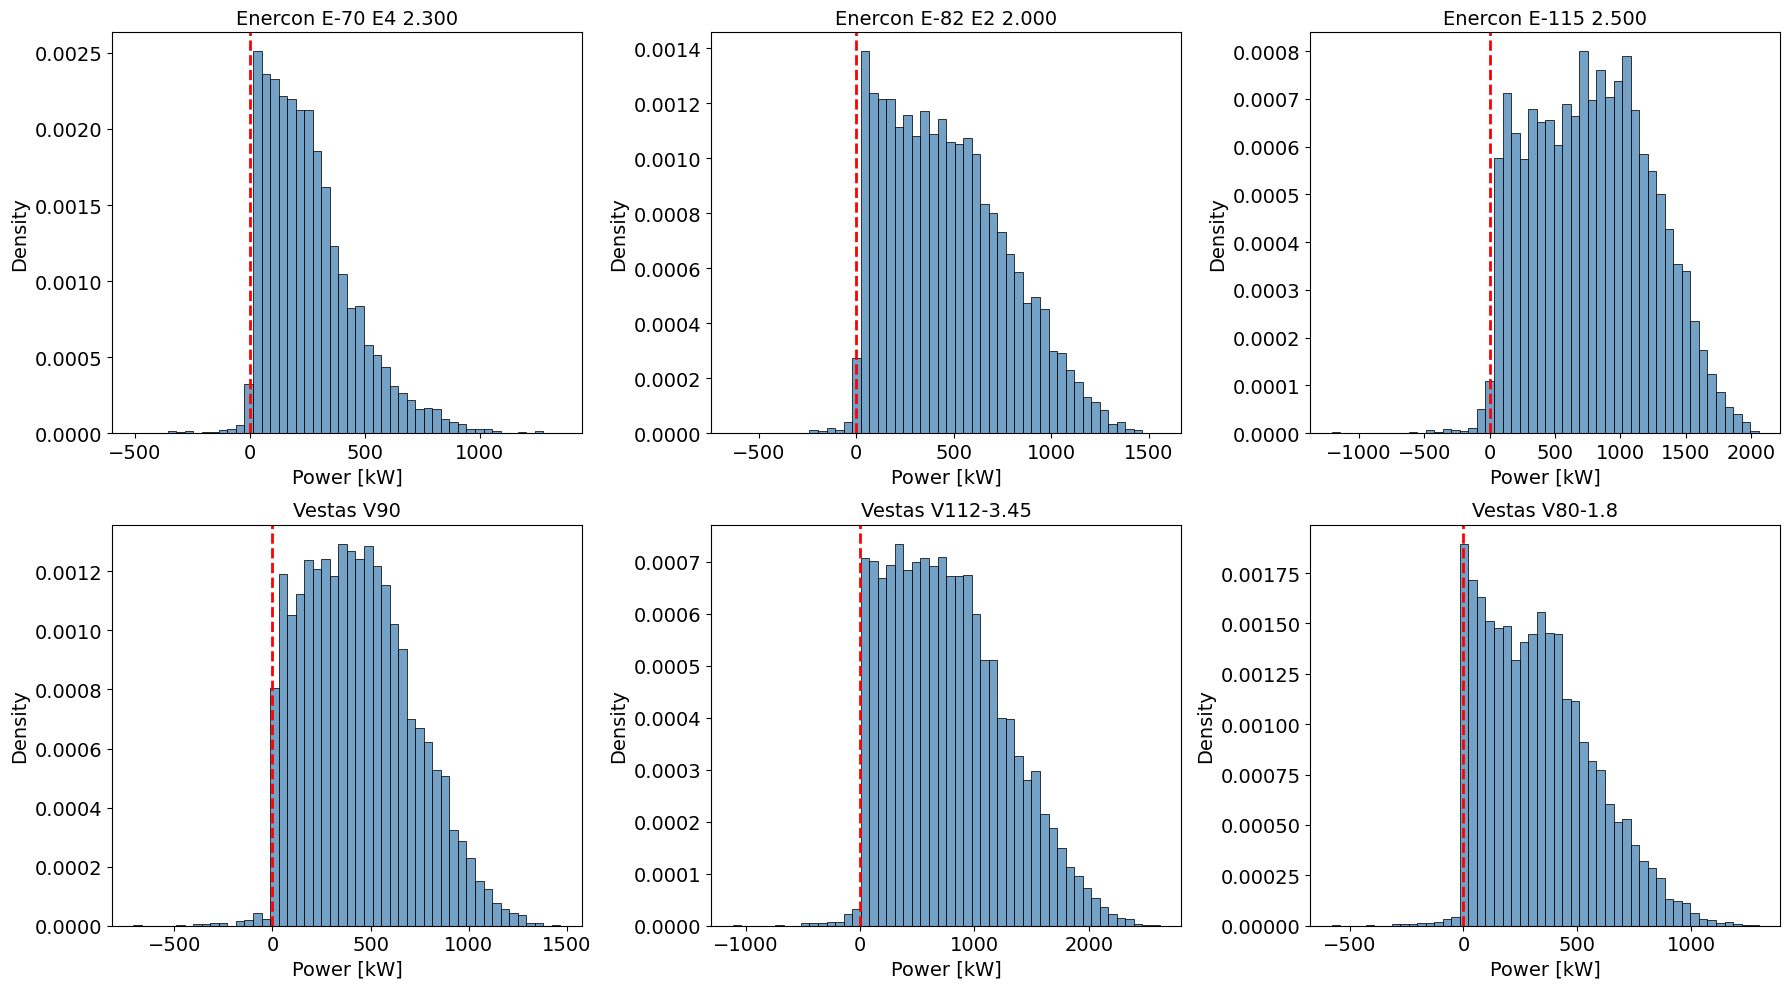

In [32]:
plot_turbine_histograms(pd.DataFrame(power_diffs), xlabel='Power [kW]')

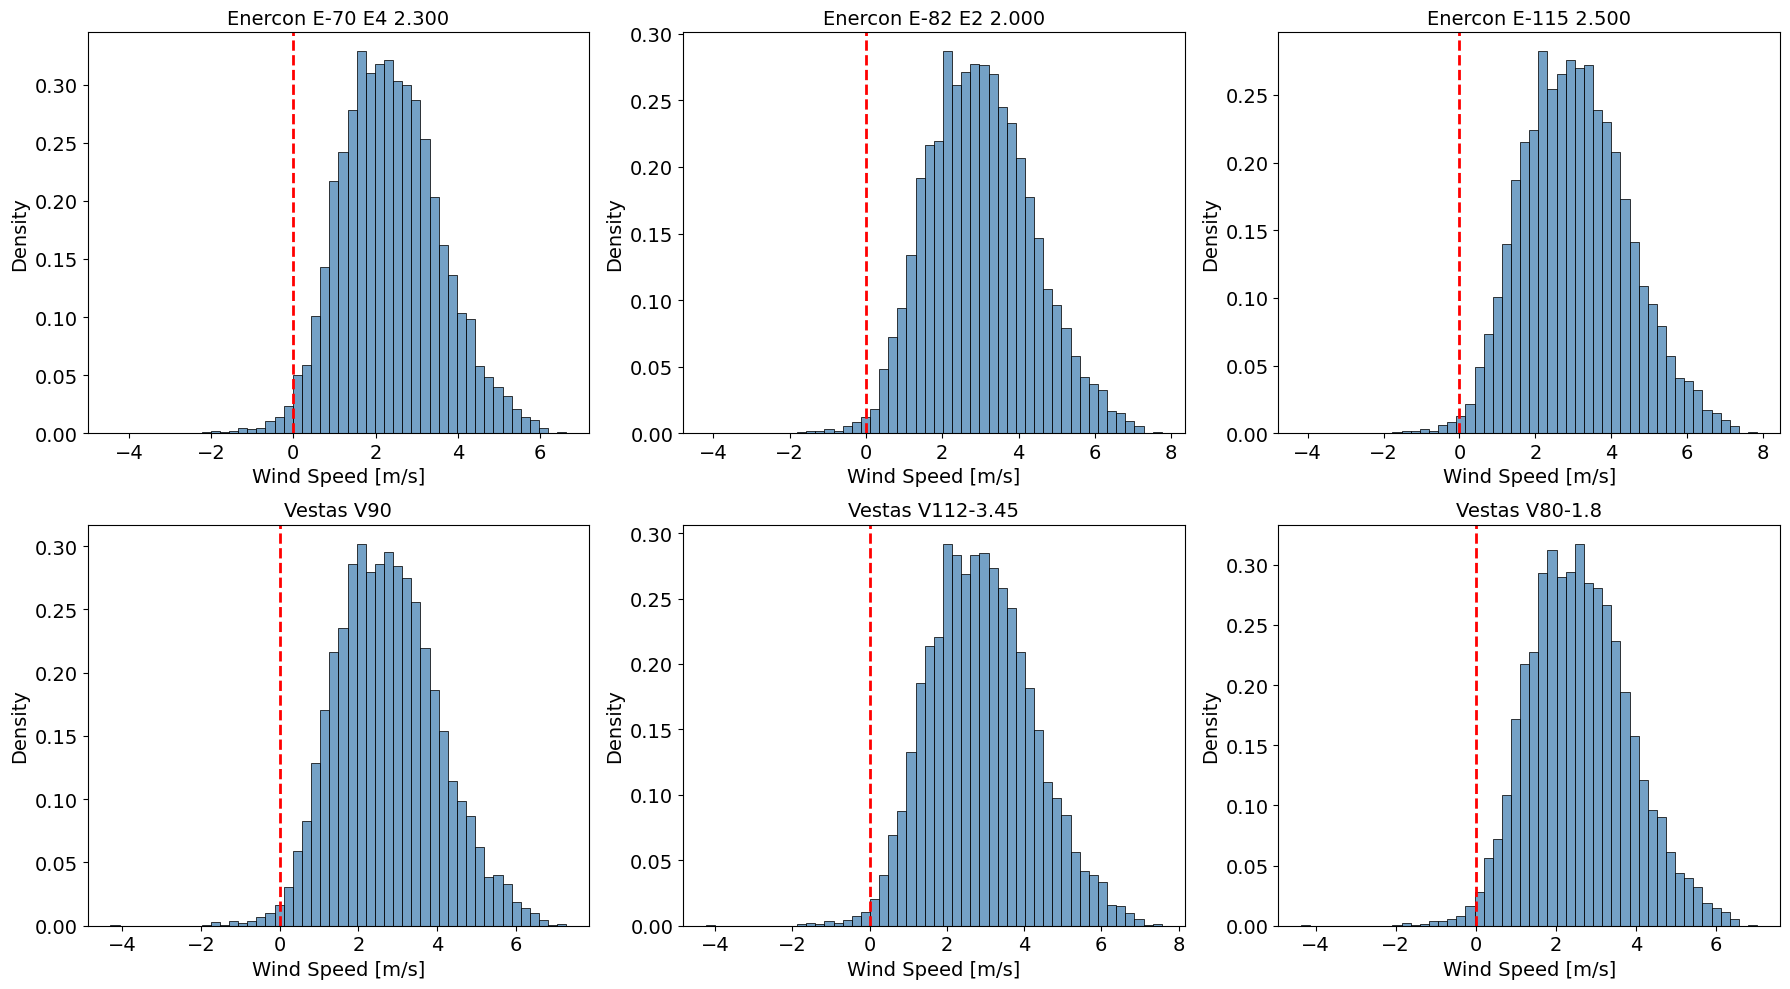

In [33]:
plot_turbine_histograms(pd.DataFrame(wind_diffs), xlabel='Wind Speed [m/s]')